In [2]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [3]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)
    
with open('point_collection/2_filled_quaternion_vertical_correction_arcore_point_cloud_collection_complete.pickle','rb') as f: 
    arcore_point_cloud_collection = pickle.load(f)
    
with open('descriptors/chosen_arcore_res5_4by5_descriptors_complete.pickle','rb') as f:
    arcore_descriptors = pickle.load(f)
    
results_path = 'testing_results'

if not os.path.exists(results_path): os.mkdir(results_path)

In [4]:
# We'll use only a 300 samples for this.
with open('sample_points.pickle','rb') as f:
    sample_points = pickle.load(f)
    
sample_points_300 = np.random.choice(1000,300,False)
    
with open('sample_arcore_points.pickle','rb') as f:
    sample_arcore_points = pickle.load(f)
    
arcore_spaces = [[],[],[],[],[],[],[]]
    
for [obj_num, name, timestamp], t_pointCloud, triangles in arcore_point_cloud_collection:
    
    unique_normals = np.unique(np.around(t_pointCloud[:,3:],decimals = 2),axis = 0)
    
    #print(obj_num, name, timestamp, len(unique_normals))
    try:
        arcore_spaces[int(obj_num)].append([
            [obj_num, name, timestamp],
            t_pointCloud, 
            triangles,
            len(unique_normals)
        ])
    except:
        continue

(1000, 300)

# Step 1.1: Raw spaces (validation)

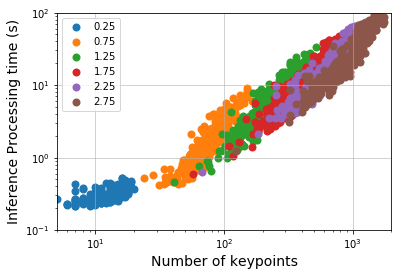

In [15]:
with open('testing_results/partial/raw_evaluation_properties.pickle','rb') as f:
    raw_evaluation_properties = pickle.load(f)
    
plt.grid(alpha = 0.7)
plt.ylim(0.1,100)
plt.xlim(5,2000)
plt.xlabel("Number of keypoints", fontsize = 14)
plt.ylabel("Inference Processing time (s)", fontsize = 14)
plt.xticks([10,100,1000],[10,100,1000])

no_cap_simp_properties = []

for radius, properties in raw_evaluation_properties:
    #properties = np.asarray(properties)
    simp_properties = []
    for ratio_s, index_s, score_s, proc_time in properties:
        simp_properties.append([
            radius, 
            ratio_s[0],
            proc_time
        ])
        
    
    simp_properties = np.asarray(simp_properties)
    plt.scatter(
        simp_properties[:,1],
        simp_properties[:,2],
        #facecolors = 'none',
        linewidth = 2,
        label = str(radius)
    )
    
    no_cap_simp_properties.append([
        radius,
        np.mean(simp_properties[:,1]),
        np.std(simp_properties[:,1]),
        np.mean(simp_properties[:,2]),
        np.std(simp_properties[:,2])
    ])

plt.xscale('log')
plt.yscale('log')
plt.legend()
    
#radius, properties[1]
no_cap_simp_properties =np.asarray(no_cap_simp_properties)

In [ ]:
descriptors = descriptors

keypoint_cap = 100

partial_results_path = os.path.join(results_path,"partial_exp")

if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)
    
exp_raw_eval_propeties = []

for radius in np.arange(0.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
        
    partial_scores_pool = []
    per_radius_properties = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        t3 = time.time()
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                desc_new = True
                #keypoint_cap,
                #strict_cap = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue
            
        t4 = time.time()

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])
                
        per_radius_properties.append([
            diff_ratios.shape,
            diff_indexs.shape,
            diff_scores.shape,
            t4 - t3
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
            print("  ",
                  diff_ratios.shape,
                  diff_indexs.shape,
                  diff_scores.shape,
                  "in {:.3f} seconds".format(t4 - t3)
                 )
                 
            with bz2.BZ2File('testing_results/partial_exp/raw_{}_partial_scores_cap_{}.pickle.bz2'.format(radius, keypoint_cap), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
            
            t1  = time.time()
            
    exp_raw_eval_propeties.append([
        radius,
        per_radius_properties
    ])
    
    with open('testing_results/partial_exp/raw_eval_properties_{}.pickle'.format(keypoint_cap), 'wb') as f:
        pickle.dump(exp_raw_eval_propeties, f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

# Step 1.2: RANSAC-generalized spaces validation

In [27]:
descriptors = descriptors

for radius in np.arange(0.5,5.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    
    print("radius =",radius)
    
    for obj_, object_name, original_vertex in sample_points: #[s_i]
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors,
                desc_new=True,
                old = True
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print(radius,"Error Rate:",)
            
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))

            t1  = time.time()
                        
            with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
    with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points_2.pickle.bz2'.format(radius), 'w') as bz2_f:
        pickle.dump(partial_scores_pool, bz2_f)

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    

radius = 0.5
0.5 Error Rate:
   0.5 : Done with 2, in 0.654 seconds. Error rate 1.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 68, in 20.924 seconds. Error rate 0.824


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 134, in 20.670 seconds. Error rate 0.858


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 200, in 20.820 seconds. Error rate 0.850


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 266, in 21.169 seconds. Error rate 0.853


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 332, in 20.937 seconds. Error rate 0.846


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 398, in 21.646 seconds. Error rate 0.842


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 464, in 21.688 seconds. Error rate 0.849


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 530, in 22.178 seconds. Error rate 0.838


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 596, in 22.630 seconds. Error rate 0.836


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 662, in 22.300 seconds. Error rate 0.841


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 728, in 22.000 seconds. Error rate 0.842


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 794, in 22.430 seconds. Error rate 0.841


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 860, in 22.935 seconds. Error rate 0.845


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 926, in 22.947 seconds. Error rate 0.844


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5 Error Rate:
   0.5 : Done with 992, in 24.554 seconds. Error rate 0.847
0.5  Total Time to match 337.236 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 2, in 0.884 seconds. Error rate 0.500


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 68, in 40.539 seconds. Error rate 0.559


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 134, in 39.946 seconds. Error rate 0.612


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 200, in 40.082 seconds. Error rate 0.610


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 266, in 39.726 seconds. Error rate 0.624


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 332, in 40.788 seconds. Error rate 0.620


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 398, in 44.313 seconds. Error rate 0.611


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 464, in 43.838 seconds. Error rate 0.601


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 530, in 46.923 seconds. Error rate 0.591


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 596, in 45.281 seconds. Error rate 0.592


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 662, in 46.874 seconds. Error rate 0.600


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 728, in 44.301 seconds. Error rate 0.595


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 794, in 46.664 seconds. Error rate 0.599


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 860, in 47.717 seconds. Error rate 0.599


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 926, in 46.890 seconds. Error rate 0.605


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.0 Error Rate:
   1.0 : Done with 992, in 50.078 seconds. Error rate 0.606
1.0  Total Time to match 689.298 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 2, in 1.677 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 68, in 83.099 seconds. Error rate 0.353


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 134, in 79.379 seconds. Error rate 0.388


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 200, in 79.263 seconds. Error rate 0.380


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 266, in 78.018 seconds. Error rate 0.353


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 332, in 80.969 seconds. Error rate 0.349


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 398, in 93.281 seconds. Error rate 0.339


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 464, in 89.226 seconds. Error rate 0.330


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 530, in 94.892 seconds. Error rate 0.323


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 596, in 95.456 seconds. Error rate 0.337


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 662, in 96.544 seconds. Error rate 0.335


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 728, in 88.782 seconds. Error rate 0.335


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 794, in 98.129 seconds. Error rate 0.331


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 860, in 93.754 seconds. Error rate 0.327


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 926, in 93.861 seconds. Error rate 0.329


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


1.5 Error Rate:
   1.5 : Done with 992, in 104.722 seconds. Error rate 0.334
1.5  Total Time to match 1405.050 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 2, in 3.569 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 68, in 143.421 seconds. Error rate 0.206


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 134, in 140.012 seconds. Error rate 0.209


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 200, in 137.774 seconds. Error rate 0.185


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 266, in 144.327 seconds. Error rate 0.184


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 332, in 147.971 seconds. Error rate 0.193


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 398, in 165.368 seconds. Error rate 0.186


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 464, in 162.194 seconds. Error rate 0.183


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 530, in 179.806 seconds. Error rate 0.175


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 596, in 173.960 seconds. Error rate 0.185


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 662, in 177.580 seconds. Error rate 0.180


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 728, in 162.141 seconds. Error rate 0.184


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 794, in 180.590 seconds. Error rate 0.185


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 860, in 171.592 seconds. Error rate 0.185


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 926, in 172.806 seconds. Error rate 0.186


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.0 Error Rate:
   2.0 : Done with 992, in 188.888 seconds. Error rate 0.186
2.0  Total Time to match 2543.509 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 2, in 5.675 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 68, in 233.694 seconds. Error rate 0.206


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 134, in 232.067 seconds. Error rate 0.179


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 200, in 224.884 seconds. Error rate 0.145


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 266, in 235.369 seconds. Error rate 0.132


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 332, in 238.247 seconds. Error rate 0.139


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 398, in 268.906 seconds. Error rate 0.128


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 464, in 265.859 seconds. Error rate 0.125


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 530, in 297.601 seconds. Error rate 0.126


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 596, in 289.908 seconds. Error rate 0.126


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 662, in 296.949 seconds. Error rate 0.124


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 728, in 268.799 seconds. Error rate 0.126


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 794, in 303.419 seconds. Error rate 0.125


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 860, in 289.355 seconds. Error rate 0.123


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 926, in 296.664 seconds. Error rate 0.124


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.5 Error Rate:
   2.5 : Done with 992, in 314.455 seconds. Error rate 0.127
2.5  Total Time to match 4202.102 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 2, in 7.351 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 68, in 340.161 seconds. Error rate 0.176


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 134, in 330.663 seconds. Error rate 0.149


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 200, in 348.471 seconds. Error rate 0.130


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 266, in 362.746 seconds. Error rate 0.109


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 332, in 364.035 seconds. Error rate 0.114


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 398, in 421.814 seconds. Error rate 0.103


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 464, in 397.065 seconds. Error rate 0.101


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 530, in 438.196 seconds. Error rate 0.096


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 596, in 421.960 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 662, in 437.254 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 728, in 405.889 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 794, in 448.941 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 860, in 444.180 seconds. Error rate 0.099


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 926, in 456.680 seconds. Error rate 0.100


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.0 Error Rate:
   3.0 : Done with 992, in 453.096 seconds. Error rate 0.099
3.0  Total Time to match 6269.163 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 2, in 7.931 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 68, in 465.331 seconds. Error rate 0.132


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 134, in 448.756 seconds. Error rate 0.119


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 200, in 451.074 seconds. Error rate 0.110


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 266, in 476.778 seconds. Error rate 0.094


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 332, in 504.692 seconds. Error rate 0.081


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 398, in 554.811 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 464, in 513.032 seconds. Error rate 0.080


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 530, in 578.572 seconds. Error rate 0.081


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 596, in 551.992 seconds. Error rate 0.082


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 662, in 580.672 seconds. Error rate 0.080


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 728, in 531.872 seconds. Error rate 0.076


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 794, in 607.395 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 860, in 587.271 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 926, in 608.268 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


3.5 Error Rate:
   3.5 : Done with 992, in 598.310 seconds. Error rate 0.079
3.5  Total Time to match 8305.965 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 2, in 9.549 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 68, in 572.654 seconds. Error rate 0.103


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 134, in 553.863 seconds. Error rate 0.097


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 200, in 545.897 seconds. Error rate 0.090


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 266, in 580.455 seconds. Error rate 0.083


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 332, in 621.924 seconds. Error rate 0.081


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 398, in 670.741 seconds. Error rate 0.073


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 464, in 636.506 seconds. Error rate 0.071


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 530, in 690.994 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 596, in 666.357 seconds. Error rate 0.072


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 662, in 714.724 seconds. Error rate 0.069


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 728, in 644.656 seconds. Error rate 0.069


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 794, in 743.892 seconds. Error rate 0.067


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 860, in 711.377 seconds. Error rate 0.067


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 926, in 738.383 seconds. Error rate 0.069


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.0 Error Rate:
   4.0 : Done with 992, in 738.933 seconds. Error rate 0.071
4.0  Total Time to match 10127.635 seconds.
radius = 4.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 2, in 12.032 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 68, in 656.178 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 134, in 660.978 seconds. Error rate 0.067


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 200, in 612.415 seconds. Error rate 0.070


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 266, in 659.215 seconds. Error rate 0.068


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 332, in 732.998 seconds. Error rate 0.084


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 398, in 768.975 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 464, in 756.492 seconds. Error rate 0.082


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 530, in 808.323 seconds. Error rate 0.085


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 596, in 763.408 seconds. Error rate 0.082


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 662, in 822.736 seconds. Error rate 0.079


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 728, in 746.892 seconds. Error rate 0.077


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 794, in 884.343 seconds. Error rate 0.076


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 860, in 823.814 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 926, in 856.634 seconds. Error rate 0.076


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


4.5 Error Rate:
   4.5 : Done with 992, in 861.569 seconds. Error rate 0.076
4.5  Total Time to match 11756.707 seconds.
radius = 5.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 2, in 14.730 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 68, in 733.020 seconds. Error rate 0.059


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 134, in 724.718 seconds. Error rate 0.067


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 200, in 686.701 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 266, in 734.560 seconds. Error rate 0.071


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 332, in 823.765 seconds. Error rate 0.069


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 398, in 851.725 seconds. Error rate 0.068


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 464, in 846.682 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 530, in 874.187 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 596, in 844.126 seconds. Error rate 0.076


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 662, in 888.087 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 728, in 838.435 seconds. Error rate 0.074


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 794, in 945.075 seconds. Error rate 0.082


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 860, in 923.543 seconds. Error rate 0.079


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 926, in 965.149 seconds. Error rate 0.078


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:698: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


5.0 Error Rate:
   5.0 : Done with 992, in 954.101 seconds. Error rate 0.079
5.0  Total Time to match 13011.702 seconds.


In [29]:
neighbor_sizes = 100*2**np.arange(0,5,2)

radius_lrange = 4.0*2**np.arange(0,1)

neighbor_sizes, radius_lrange

(array([ 100,  400, 1600]), array([4.]))

In [28]:

for radius in [2.0]:#radius_lrange:
    
    t0 = time.time()
    t1 = t0
    
    norm_cdf_values = []
    
    print("radius =",radius)
    
    for obj_, object_name, original_vertex in sample_points:
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        if len(pointCloud) == 0: continue
            
        per_space_values = []
            
        for neighbor_size in neighbor_sizes:

            t0 = time.time()

            nbrs = NearestNeighbors(n_neighbors=min(neighbor_size,len(pointCloud)), algorithm='kd_tree').fit(pointCloud[:,:3])
            distances, indices = nbrs.kneighbors(pointCloud[:,:3])

            try:
                nearby_normals = pointCloud[indices,3:6]
                refrnc_normals = np.reshape(np.repeat(pointCloud[:,3:6],min(neighbor_size,len(pointCloud)),axis=0),nearby_normals.shape)

                normal_product = np.sum(np.multiply(refrnc_normals,nearby_normals),axis=2)

                #print(nearby_normals.shape, refrnc_normals.shape, normal_product.shape)
            except Exception as e1:
                print("Error while getting normals,", e1)

            color = np.mean(np.abs(normal_product))
            hist, values = np.histogram(np.mean(np.abs(normal_product),axis = 1), bins = np.arange(0,1.01,0.01))
            hist_all, values_all = np.histogram(np.abs(normal_product), bins = np.arange(0,1.01,0.01))
            CY = np.cumsum(hist/np.sum(hist))

            per_space_values.append([
                hist,
                CY,
                values,
                hist_all, 
                values_all,
                neighbor_size,
                len(pointCloud)
            ])
    
        norm_cdf_values.append([
            [obj_, object_name, original_vertex],
            per_space_values
        ])
        
        if len(norm_cdf_values) % 66 == 2:
            
            print("  ",radius,": Done with {}, in {:.3f} seconds.".format(
                len(norm_cdf_values),
                time.time()-t1
            ))
                
            t1 = time.time()
            
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_sim_hist.pickle.bz2'.format(radius), 'w') as bz2_f:
            pickle.dump(norm_cdf_values, bz2_f)

    print(radius," Total Time to compute similarities {:.3f} seconds.".format(time.time()-t0))
    

radius = 2.0
   2.0 : Done with 2, in 4.884 seconds.
   2.0 : Done with 68, in 224.091 seconds.
   2.0 : Done with 134, in 219.854 seconds.
   2.0 : Done with 200, in 226.952 seconds.
   2.0 : Done with 266, in 229.900 seconds.
   2.0 : Done with 332, in 243.996 seconds.
   2.0 : Done with 398, in 276.056 seconds.
   2.0 : Done with 464, in 270.697 seconds.
   2.0 : Done with 530, in 306.356 seconds.
   2.0 : Done with 596, in 306.344 seconds.
   2.0 : Done with 662, in 301.453 seconds.
   2.0 : Done with 728, in 279.061 seconds.
   2.0 : Done with 794, in 322.224 seconds.
   2.0 : Done with 860, in 317.757 seconds.
   2.0 : Done with 926, in 317.368 seconds.
   2.0 : Done with 992, in 347.038 seconds.
2.0  Total Time to compute similarities 3.995 seconds.


In [6]:
descriptors = descriptors

for keypoint_cap in [30,50,70]:

#keypoint_cap = 100

    partial_results_path = os.path.join(results_path,"partial_capped_"+str(keypoint_cap))

    if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)

    exp_eval_propeties = []

    for radius in np.arange(0.25,3.1,0.5):

        t0 = time.time()
        t1 = time.time()

        partial_scores_pool = []
        per_radius_properties = []

        print("radius =",radius)

        for s_i in sample_points_300:

            t3 = time.time()

            obj_, object_name, original_vertex = sample_points[s_i]

            pointCloud = []

            try:
                trial = np.random.randint(5)

                with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                    ransac_trial_point_collection = pickle.load(f)

                object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

                ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

                dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
                pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            except:
                print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
                continue

            t4 = time.time()

            #if len(gen_planes) == 0: continue
            if len(pointCloud) == 0: continue

            local_keypoint_matches = []

            try:
                obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                    [obj_, object_name, original_vertex], 
                    pointCloud, 
                    descriptors,
                    key_cap=keypoint_cap,
                    strict_cap=True
                )

            except Exception as ex:
                print(ex)
                print("skipped",object_name)
                continue

            if len(local_keypoint_matches) == 0: 
                print("skipped",object_name)
                continue

            t5 = time.time()

            partial_scores_pool.append([
                [obj_, object_name, original_vertex], 
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            per_radius_properties.append([
                diff_ratios.shape,
                diff_indexs.shape,
                diff_scores.shape,
                [t5 - t4, t4 -t3] # inference time, extraction time
            ])

            if len(partial_scores_pool) % 66 == 2:

                partial_errors_pool = NN_matcher(partial_scores_pool)
                print(keypoint_cap,"  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                    len(partial_scores_pool),
                    time.time()-t1,
                    np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
                ))
                print("  ",
                      diff_ratios.shape,
                      diff_indexs.shape,
                      diff_scores.shape,
                      "extrated in {:.3f} seconds, inferred in {:.3f} seconds".format(t4 - t3, t5 - t4)
                     )

                t1  = time.time()
                
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)

        exp_eval_propeties.append([
            radius,
            per_radius_properties
        ])

        with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'wb') as f:
            pickle.dump(exp_eval_propeties,f)

        print(keypoint_cap,radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))


radius = 0.25
30    0.25 : Done with 2, in 0.689 seconds. Error rate 1.000
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.050 seconds, inferred in 0.271 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 68, in 24.225 seconds. Error rate 0.882
   (14, 7) (14, 7, 2) (14, 7, 2) extrated in 0.036 seconds, inferred in 0.279 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 134, in 27.557 seconds. Error rate 0.873
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.035 seconds, inferred in 0.272 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 200, in 33.518 seconds. Error rate 0.875
   (11, 7) (11, 7, 2) (11, 7, 2) extrated in 0.024 seconds, inferred in 0.255 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.25 : Done with 266, in 37.458 seconds. Error rate 0.876
   (17, 7) (17, 7, 2) (17, 7, 2) extrated in 0.036 seconds, inferred in 0.345 seconds
30 0.25  Total Time to match 143.417 seconds.
radius = 0.75
30    0.75 : Done with 2, in 1.651 seconds. Error rate 1.000
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 0.965 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 68, in 56.184 seconds. Error rate 0.794
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.060 seconds, inferred in 0.818 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 134, in 72.256 seconds. Error rate 0.761
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.048 seconds, inferred in 0.897 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 200, in 82.479 seconds. Error rate 0.775
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.037 seconds, inferred in 0.913 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    0.75 : Done with 266, in 96.762 seconds. Error rate 0.789
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 0.842 seconds
30 0.75  Total Time to match 361.530 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.25 : Done with 2, in 1.928 seconds. Error rate 0.500
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 1.147 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.25 : Done with 68, in 70.729 seconds. Error rate 0.824
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.033 seconds, inferred in 1.048 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.25 : Done with 134, in 86.508 seconds. Error rate 0.776
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.073 seconds, inferred in 1.097 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    1.25 : Done with 200, in 93.160 seconds. Error rate 0.760
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.049 seconds, inferred in 1.120 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    1.25 : Done with 266, in 110.195 seconds. Error rate 0.759
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.039 seconds, inferred in 2.646 seconds
30 1.25  Total Time to match 425.189 seconds.
radius = 1.75
30    1.75 : Done with 2, in 2.363 seconds. Error rate 1.000
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.046 seconds, inferred in 1.278 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.75 : Done with 68, in 77.158 seconds. Error rate 0.647
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.033 seconds, inferred in 0.976 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.75 : Done with 134, in 93.625 seconds. Error rate 0.642
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.048 seconds, inferred in 1.031 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.75 : Done with 200, in 101.657 seconds. Error rate 0.620
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.047 seconds, inferred in 0.981 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    1.75 : Done with 266, in 119.304 seconds. Error rate 0.605
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 2.454 seconds
30 1.75  Total Time to match 459.734 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    2.25 : Done with 2, in 2.344 seconds. Error rate 0.500
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.039 seconds, inferred in 1.319 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    2.25 : Done with 68, in 77.794 seconds. Error rate 0.618
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.033 seconds, inferred in 0.847 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    2.25 : Done with 134, in 93.887 seconds. Error rate 0.634
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.048 seconds, inferred in 1.044 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    2.25 : Done with 200, in 100.705 seconds. Error rate 0.615
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.046 seconds, inferred in 1.057 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    2.25 : Done with 266, in 113.830 seconds. Error rate 0.617
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 1.877 seconds
30 2.25  Total Time to match 452.718 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


30    2.75 : Done with 2, in 2.553 seconds. Error rate 0.500
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 1.433 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    2.75 : Done with 68, in 84.897 seconds. Error rate 0.618
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.032 seconds, inferred in 0.780 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    2.75 : Done with 134, in 101.366 seconds. Error rate 0.590
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.047 seconds, inferred in 1.093 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    2.75 : Done with 200, in 104.299 seconds. Error rate 0.590
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.048 seconds, inferred in 1.074 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


30    2.75 : Done with 266, in 118.667 seconds. Error rate 0.579
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.039 seconds, inferred in 1.792 seconds
30 2.75  Total Time to match 477.731 seconds.
radius = 0.25
50    0.25 : Done with 2, in 0.589 seconds. Error rate 1.000
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.036 seconds, inferred in 0.255 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.25 : Done with 68, in 21.459 seconds. Error rate 0.868
   (11, 7) (11, 7, 2) (11, 7, 2) extrated in 0.032 seconds, inferred in 0.240 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.25 : Done with 134, in 28.228 seconds. Error rate 0.873
   (15, 7) (15, 7, 2) (15, 7, 2) extrated in 0.047 seconds, inferred in 0.301 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.25 : Done with 200, in 32.741 seconds. Error rate 0.855
   (19, 7) (19, 7, 2) (19, 7, 2) extrated in 0.038 seconds, inferred in 0.346 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.25 : Done with 266, in 37.035 seconds. Error rate 0.857
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.033 seconds, inferred in 0.247 seconds
50 0.25  Total Time to match 140.177 seconds.
radius = 0.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    0.75 : Done with 2, in 2.152 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 1.359 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    0.75 : Done with 68, in 77.781 seconds. Error rate 0.794
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.037 seconds, inferred in 1.113 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    0.75 : Done with 134, in 96.317 seconds. Error rate 0.813
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.049 seconds, inferred in 1.226 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.75 : Done with 200, in 112.348 seconds. Error rate 0.805
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.051 seconds, inferred in 1.246 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.75 : Done with 266, in 140.723 seconds. Error rate 0.801
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 3.090 seconds
50 0.75  Total Time to match 512.068 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.25 : Done with 2, in 2.988 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 1.816 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.25 : Done with 68, in 107.073 seconds. Error rate 0.750
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.035 seconds, inferred in 1.551 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.25 : Done with 134, in 129.602 seconds. Error rate 0.694
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.091 seconds, inferred in 1.800 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.25 : Done with 200, in 143.830 seconds. Error rate 0.685
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.084 seconds, inferred in 1.856 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.25 : Done with 266, in 168.791 seconds. Error rate 0.669
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.043 seconds, inferred in 3.839 seconds
50 1.25  Total Time to match 644.230 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.75 : Done with 2, in 3.054 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.040 seconds, inferred in 1.611 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.75 : Done with 68, in 100.960 seconds. Error rate 0.647
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.034 seconds, inferred in 1.146 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.75 : Done with 134, in 125.751 seconds. Error rate 0.649
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.049 seconds, inferred in 1.498 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.75 : Done with 200, in 142.266 seconds. Error rate 0.615
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.047 seconds, inferred in 1.467 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.75 : Done with 266, in 164.950 seconds. Error rate 0.583
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 2.964 seconds
50 1.75  Total Time to match 629.243 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.25 : Done with 2, in 3.632 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 2.108 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.25 : Done with 68, in 109.648 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.033 seconds, inferred in 1.168 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.25 : Done with 134, in 152.292 seconds. Error rate 0.537
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.047 seconds, inferred in 1.783 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.25 : Done with 200, in 154.233 seconds. Error rate 0.575
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.048 seconds, inferred in 1.654 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.25 : Done with 266, in 190.257 seconds. Error rate 0.598
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 3.193 seconds
50 2.25  Total Time to match 714.726 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.75 : Done with 2, in 3.848 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 2.133 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.75 : Done with 68, in 128.985 seconds. Error rate 0.559
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.032 seconds, inferred in 1.463 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.75 : Done with 134, in 163.232 seconds. Error rate 0.575
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.053 seconds, inferred in 1.649 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.75 : Done with 200, in 162.630 seconds. Error rate 0.575
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.047 seconds, inferred in 1.658 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.75 : Done with 266, in 183.565 seconds. Error rate 0.538
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 2.962 seconds
50 2.75  Total Time to match 749.645 seconds.
radius = 0.25
70    0.25 : Done with 2, in 0.611 seconds. Error rate 1.000
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.038 seconds, inferred in 0.263 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    0.25 : Done with 68, in 24.138 seconds. Error rate 0.809
   (9, 7) (9, 7, 2) (9, 7, 2) extrated in 0.039 seconds, inferred in 0.300 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    0.25 : Done with 134, in 28.746 seconds. Error rate 0.851
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.049 seconds, inferred in 0.256 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    0.25 : Done with 200, in 33.193 seconds. Error rate 0.850
   (11, 7) (11, 7, 2) (11, 7, 2) extrated in 0.033 seconds, inferred in 0.238 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    0.25 : Done with 266, in 37.666 seconds. Error rate 0.842
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.032 seconds, inferred in 0.257 seconds
70 0.25  Total Time to match 144.955 seconds.
radius = 0.75
70    0.75 : Done with 2, in 3.107 seconds. Error rate 1.000
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.037 seconds, inferred in 2.136 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    0.75 : Done with 68, in 108.607 seconds. Error rate 0.721
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.037 seconds, inferred in 1.679 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    0.75 : Done with 134, in 134.859 seconds. Error rate 0.754
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.049 seconds, inferred in 1.894 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    0.75 : Done with 200, in 149.537 seconds. Error rate 0.775
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.050 seconds, inferred in 1.726 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    0.75 : Done with 266, in 187.091 seconds. Error rate 0.805
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.038 seconds, inferred in 4.726 seconds
70 0.75  Total Time to match 686.093 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.25 : Done with 2, in 3.235 seconds. Error rate 0.500
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.037 seconds, inferred in 2.008 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.25 : Done with 68, in 134.073 seconds. Error rate 0.662
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.034 seconds, inferred in 1.983 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.25 : Done with 134, in 170.406 seconds. Error rate 0.657
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.048 seconds, inferred in 2.111 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    1.25 : Done with 200, in 188.681 seconds. Error rate 0.650
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.047 seconds, inferred in 2.445 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


70    1.25 : Done with 266, in 223.131 seconds. Error rate 0.650
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.038 seconds, inferred in 5.226 seconds
70 1.25  Total Time to match 846.196 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.75 : Done with 2, in 4.012 seconds. Error rate 0.500
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.038 seconds, inferred in 2.266 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.75 : Done with 68, in 130.903 seconds. Error rate 0.515
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.032 seconds, inferred in 1.671 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.75 : Done with 134, in 181.817 seconds. Error rate 0.537
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.050 seconds, inferred in 2.253 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.75 : Done with 200, in 198.043 seconds. Error rate 0.580
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.047 seconds, inferred in 2.438 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    1.75 : Done with 266, in 239.472 seconds. Error rate 0.575
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.038 seconds, inferred in 4.409 seconds
70 1.75  Total Time to match 887.774 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.25 : Done with 2, in 5.020 seconds. Error rate 0.500
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.038 seconds, inferred in 2.905 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.25 : Done with 68, in 157.332 seconds. Error rate 0.574
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.037 seconds, inferred in 1.484 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.25 : Done with 134, in 198.064 seconds. Error rate 0.500
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.051 seconds, inferred in 2.421 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.25 : Done with 200, in 199.398 seconds. Error rate 0.485
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.047 seconds, inferred in 1.847 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.25 : Done with 266, in 245.750 seconds. Error rate 0.470
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.041 seconds, inferred in 3.935 seconds
70 2.25  Total Time to match 937.611 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.75 : Done with 2, in 5.032 seconds. Error rate 0.000
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.039 seconds, inferred in 2.785 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.75 : Done with 68, in 154.983 seconds. Error rate 0.471
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.033 seconds, inferred in 1.536 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.75 : Done with 134, in 215.280 seconds. Error rate 0.470
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.048 seconds, inferred in 2.154 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.75 : Done with 200, in 224.983 seconds. Error rate 0.420
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.048 seconds, inferred in 2.295 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


70    2.75 : Done with 266, in 250.554 seconds. Error rate 0.444
   (70, 7) (70, 7, 2) (70, 7, 2) extrated in 0.038 seconds, inferred in 3.481 seconds
70 2.75  Total Time to match 993.585 seconds.


In [21]:
descriptors = descriptors

for keypoint_cap in [100,250,300]:

#keypoint_cap = 100

    partial_results_path = os.path.join(results_path,"partial_capped_"+str(keypoint_cap))

    if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)

    exp_eval_propeties = []

    for radius in np.arange(0.25,3.1,0.5):

        t0 = time.time()
        t1 = time.time()

        partial_scores_pool = []
        per_radius_properties = []

        print("radius =",radius)

        for s_i in sample_points_300:

            t3 = time.time()

            obj_, object_name, original_vertex = sample_points[s_i]

            pointCloud = []

            try:
                trial = np.random.randint(5)

                with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                    ransac_trial_point_collection = pickle.load(f)

                object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

                ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

                dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
                pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            except:
                print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
                continue

            t4 = time.time()

            #if len(gen_planes) == 0: continue
            if len(pointCloud) == 0: continue

            local_keypoint_matches = []

            try:
                obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                    [obj_, object_name, original_vertex], 
                    pointCloud, 
                    descriptors,
                    key_cap=keypoint_cap,
                    strict_cap=True
                )

            except Exception as ex:
                print(ex)
                print("skipped",object_name)
                continue

            if len(local_keypoint_matches) == 0: 
                print("skipped",object_name)
                continue

            t5 = time.time()

            partial_scores_pool.append([
                [obj_, object_name, original_vertex], 
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            per_radius_properties.append([
                diff_ratios.shape,
                diff_indexs.shape,
                diff_scores.shape,
                [t5 - t4, t4 -t3] # inference time, extraction time
            ])

            if len(partial_scores_pool) % 66 == 2:

                partial_errors_pool = NN_matcher(partial_scores_pool)
                print(keypoint_cap,"  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                    len(partial_scores_pool),
                    time.time()-t1,
                    np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
                ))
                print("  ",
                      diff_ratios.shape,
                      diff_indexs.shape,
                      diff_scores.shape,
                      "extrated in {:.3f} seconds, inferred in {:.3f} seconds".format(t4 - t3, t5 - t4)
                     )

                t1  = time.time()
                
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)

        exp_eval_propeties.append([
            radius,
            per_radius_properties
        ])

        with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'wb') as f:
            pickle.dump(exp_eval_propeties,f)

        print(keypoint_cap,radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))


radius = 0.25
100    0.25 : Done with 2, in 0.664 seconds. Error rate 1.000
   (11, 7) (11, 7, 2) (11, 7, 2) extrated in 0.044 seconds, inferred in 0.270 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.25 : Done with 68, in 21.832 seconds. Error rate 0.824
   (12, 7) (12, 7, 2) (12, 7, 2) extrated in 0.033 seconds, inferred in 0.239 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.25 : Done with 134, in 26.898 seconds. Error rate 0.851
   (14, 7) (14, 7, 2) (14, 7, 2) extrated in 0.047 seconds, inferred in 0.276 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.25 : Done with 200, in 33.657 seconds. Error rate 0.845
   (18, 7) (18, 7, 2) (18, 7, 2) extrated in 0.046 seconds, inferred in 0.327 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.25 : Done with 266, in 36.430 seconds. Error rate 0.842
   (12, 7) (12, 7, 2) (12, 7, 2) extrated in 0.027 seconds, inferred in 0.249 seconds
100 0.25  Total Time to match 139.905 seconds.
radius = 0.75
100    0.75 : Done with 2, in 3.098 seconds. Error rate 1.000
   (91, 7) (91, 7, 2) (91, 7, 2) extrated in 0.038 seconds, inferred in 2.214 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    0.75 : Done with 68, in 110.839 seconds. Error rate 0.735
   (96, 7) (96, 7, 2) (96, 7, 2) extrated in 0.033 seconds, inferred in 1.916 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    0.75 : Done with 134, in 141.985 seconds. Error rate 0.716
   (84, 7) (84, 7, 2) (84, 7, 2) extrated in 0.048 seconds, inferred in 1.891 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.75 : Done with 200, in 163.357 seconds. Error rate 0.725
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.047 seconds, inferred in 2.081 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.75 : Done with 266, in 203.120 seconds. Error rate 0.752
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 5.431 seconds
100 0.75  Total Time to match 740.627 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.25 : Done with 2, in 4.285 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 2.630 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.25 : Done with 68, in 163.204 seconds. Error rate 0.588
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.037 seconds, inferred in 2.321 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.25 : Done with 134, in 210.358 seconds. Error rate 0.590
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.048 seconds, inferred in 2.661 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.25 : Done with 200, in 239.998 seconds. Error rate 0.610
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 2.980 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.25 : Done with 266, in 285.252 seconds. Error rate 0.628
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.091 seconds, inferred in 6.902 seconds
100 1.25  Total Time to match 1077.969 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.75 : Done with 2, in 6.428 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.042 seconds, inferred in 3.707 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.75 : Done with 68, in 192.291 seconds. Error rate 0.544
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.033 seconds, inferred in 2.719 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.75 : Done with 134, in 254.717 seconds. Error rate 0.493
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 2.779 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.75 : Done with 200, in 284.125 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 3.335 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.75 : Done with 266, in 333.444 seconds. Error rate 0.515
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.037 seconds, inferred in 5.597 seconds
100 1.75  Total Time to match 1246.092 seconds.
radius = 2.25
100    2.25 : Done with 2, in 6.533 seconds. Error rate 1.000
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.037 seconds, inferred in 3.624 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.25 : Done with 68, in 213.610 seconds. Error rate 0.471
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.041 seconds, inferred in 2.553 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.25 : Done with 134, in 264.472 seconds. Error rate 0.433
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 2.628 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.25 : Done with 200, in 277.369 seconds. Error rate 0.435
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.048 seconds, inferred in 2.752 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.25 : Done with 266, in 320.387 seconds. Error rate 0.440
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 6.531 seconds
100 2.25  Total Time to match 1266.378 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.75 : Done with 2, in 7.679 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 4.232 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.75 : Done with 68, in 218.795 seconds. Error rate 0.412
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.035 seconds, inferred in 2.128 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.75 : Done with 134, in 283.790 seconds. Error rate 0.455
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 3.415 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.75 : Done with 200, in 311.259 seconds. Error rate 0.445
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.047 seconds, inferred in 3.448 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.75 : Done with 266, in 341.078 seconds. Error rate 0.444
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 4.529 seconds
100 2.75  Total Time to match 1360.528 seconds.
radius = 0.25
250    0.25 : Done with 2, in 0.603 seconds. Error rate 1.000
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.038 seconds, inferred in 0.264 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.25 : Done with 68, in 21.985 seconds. Error rate 0.853
   (12, 7) (12, 7, 2) (12, 7, 2) extrated in 0.033 seconds, inferred in 0.238 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.25 : Done with 134, in 26.865 seconds. Error rate 0.851
   (12, 7) (12, 7, 2) (12, 7, 2) extrated in 0.046 seconds, inferred in 0.256 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.25 : Done with 200, in 32.007 seconds. Error rate 0.860
   (10, 7) (10, 7, 2) (10, 7, 2) extrated in 0.038 seconds, inferred in 0.235 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.25 : Done with 266, in 36.766 seconds. Error rate 0.857
   (14, 7) (14, 7, 2) (14, 7, 2) extrated in 0.036 seconds, inferred in 0.293 seconds
250 0.25  Total Time to match 137.077 seconds.
radius = 0.75
250    0.75 : Done with 2, in 3.499 seconds. Error rate 1.000
   (99, 7) (99, 7, 2) (99, 7, 2) extrated in 0.040 seconds, inferred in 2.463 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    0.75 : Done with 68, in 115.576 seconds. Error rate 0.750
   (95, 7) (95, 7, 2) (95, 7, 2) extrated in 0.041 seconds, inferred in 2.189 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    0.75 : Done with 134, in 168.664 seconds. Error rate 0.761
   (80, 7) (80, 7, 2) (80, 7, 2) extrated in 0.047 seconds, inferred in 2.129 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.75 : Done with 200, in 196.301 seconds. Error rate 0.750
   (106, 7) (106, 7, 2) (106, 7, 2) extrated in 0.048 seconds, inferred in 2.733 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.75 : Done with 266, in 238.729 seconds. Error rate 0.767
   (141, 7) (141, 7, 2) (141, 7, 2) extrated in 0.060 seconds, inferred in 9.174 seconds
250 0.75  Total Time to match 869.309 seconds.
radius = 1.25
250    1.25 : Done with 2, in 11.092 seconds. Error rate 1.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 7.620 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.25 : Done with 68, in 340.489 seconds. Error rate 0.559
   (232, 7) (232, 7, 2) (232, 7, 2) extrated in 0.035 seconds, inferred in 5.182 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.25 : Done with 134, in 412.415 seconds. Error rate 0.507
   (217, 7) (217, 7, 2) (217, 7, 2) extrated in 0.051 seconds, inferred in 5.543 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    1.25 : Done with 200, in 473.576 seconds. Error rate 0.495
   (232, 7) (232, 7, 2) (232, 7, 2) extrated in 0.047 seconds, inferred in 6.391 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    1.25 : Done with 266, in 559.309 seconds. Error rate 0.485
   (182, 7) (182, 7, 2) (182, 7, 2) extrated in 0.025 seconds, inferred in 2.688 seconds
250 1.25  Total Time to match 2135.357 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.75 : Done with 2, in 14.435 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.038 seconds, inferred in 8.286 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.75 : Done with 68, in 470.118 seconds. Error rate 0.412
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.033 seconds, inferred in 6.193 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.75 : Done with 134, in 580.391 seconds. Error rate 0.366
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.048 seconds, inferred in 6.719 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.75 : Done with 200, in 665.694 seconds. Error rate 0.335
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.048 seconds, inferred in 8.011 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.75 : Done with 266, in 762.076 seconds. Error rate 0.320
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 17.460 seconds
250 1.75  Total Time to match 2933.335 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.25 : Done with 2, in 17.192 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.038 seconds, inferred in 9.926 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.25 : Done with 68, in 509.727 seconds. Error rate 0.265
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.034 seconds, inferred in 4.993 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.25 : Done with 134, in 634.225 seconds. Error rate 0.306
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.048 seconds, inferred in 7.483 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.25 : Done with 200, in 724.404 seconds. Error rate 0.280
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.049 seconds, inferred in 7.680 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.25 : Done with 266, in 814.294 seconds. Error rate 0.252
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 12.902 seconds
250 2.25  Total Time to match 3156.941 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.75 : Done with 2, in 18.538 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.045 seconds, inferred in 10.508 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.75 : Done with 68, in 535.939 seconds. Error rate 0.162
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.036 seconds, inferred in 5.848 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.75 : Done with 134, in 741.140 seconds. Error rate 0.209
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.049 seconds, inferred in 8.042 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.75 : Done with 200, in 767.648 seconds. Error rate 0.215
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.054 seconds, inferred in 7.902 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.75 : Done with 266, in 828.092 seconds. Error rate 0.211
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.038 seconds, inferred in 10.995 seconds
250 2.75  Total Time to match 3377.988 seconds.
radius = 0.25
300    0.25 : Done with 2, in 0.659 seconds. Error rate 1.000
   (12, 7) (12, 7, 2) (12, 7, 2) extrated in 0.047 seconds, inferred in 0.276 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.25 : Done with 68, in 22.899 seconds. Error rate 0.809
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.033 seconds, inferred in 0.256 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.25 : Done with 134, in 27.977 seconds. Error rate 0.851
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.046 seconds, inferred in 0.291 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.25 : Done with 200, in 33.901 seconds. Error rate 0.865
   (13, 7) (13, 7, 2) (13, 7, 2) extrated in 0.047 seconds, inferred in 0.279 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.25 : Done with 266, in 38.007 seconds. Error rate 0.853
   (19, 7) (19, 7, 2) (19, 7, 2) extrated in 0.046 seconds, inferred in 0.437 seconds
300 0.25  Total Time to match 144.878 seconds.
radius = 0.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    0.75 : Done with 2, in 3.852 seconds. Error rate 0.500
   (96, 7) (96, 7, 2) (96, 7, 2) extrated in 0.038 seconds, inferred in 2.763 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    0.75 : Done with 68, in 135.672 seconds. Error rate 0.721
   (91, 7) (91, 7, 2) (91, 7, 2) extrated in 0.033 seconds, inferred in 2.157 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    0.75 : Done with 134, in 170.490 seconds. Error rate 0.731
   (79, 7) (79, 7, 2) (79, 7, 2) extrated in 0.048 seconds, inferred in 2.148 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    0.75 : Done with 200, in 202.850 seconds. Error rate 0.755
   (93, 7) (93, 7, 2) (93, 7, 2) extrated in 0.038 seconds, inferred in 2.231 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    0.75 : Done with 266, in 237.082 seconds. Error rate 0.778
   (60, 7) (60, 7, 2) (60, 7, 2) extrated in 0.036 seconds, inferred in 1.416 seconds
300 0.75  Total Time to match 889.219 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.25 : Done with 2, in 12.003 seconds. Error rate 0.500
   (272, 7) (272, 7, 2) (272, 7, 2) extrated in 0.043 seconds, inferred in 8.336 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.25 : Done with 68, in 382.112 seconds. Error rate 0.529
   (221, 7) (221, 7, 2) (221, 7, 2) extrated in 0.038 seconds, inferred in 5.633 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.25 : Done with 134, in 492.956 seconds. Error rate 0.537
   (222, 7) (222, 7, 2) (222, 7, 2) extrated in 0.049 seconds, inferred in 6.465 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.25 : Done with 200, in 554.774 seconds. Error rate 0.520
   (286, 7) (286, 7, 2) (286, 7, 2) extrated in 0.050 seconds, inferred in 9.442 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.25 : Done with 266, in 658.236 seconds. Error rate 0.500
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.039 seconds, inferred in 21.419 seconds
300 1.25  Total Time to match 2469.630 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.75 : Done with 2, in 17.566 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.037 seconds, inferred in 9.646 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.75 : Done with 68, in 553.869 seconds. Error rate 0.397
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 7.500 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.75 : Done with 134, in 714.400 seconds. Error rate 0.366
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.048 seconds, inferred in 8.602 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.75 : Done with 200, in 748.264 seconds. Error rate 0.335
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.047 seconds, inferred in 9.164 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.75 : Done with 266, in 908.955 seconds. Error rate 0.331
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.046 seconds, inferred in 18.256 seconds
300 1.75  Total Time to match 3451.896 seconds.
radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.25 : Done with 2, in 22.006 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.047 seconds, inferred in 12.854 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.25 : Done with 68, in 625.642 seconds. Error rate 0.265
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.045 seconds, inferred in 7.209 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.25 : Done with 134, in 756.819 seconds. Error rate 0.254
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.049 seconds, inferred in 8.729 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.25 : Done with 200, in 852.649 seconds. Error rate 0.225
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.048 seconds, inferred in 8.836 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.25 : Done with 266, in 983.368 seconds. Error rate 0.229
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.039 seconds, inferred in 18.345 seconds
300 2.25  Total Time to match 3786.502 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.75 : Done with 2, in 18.483 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.037 seconds, inferred in 10.381 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.75 : Done with 68, in 665.845 seconds. Error rate 0.250
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 6.832 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.75 : Done with 134, in 861.076 seconds. Error rate 0.254
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.049 seconds, inferred in 9.311 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.75 : Done with 200, in 840.009 seconds. Error rate 0.230
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.050 seconds, inferred in 10.829 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.75 : Done with 266, in 1012.845 seconds. Error rate 0.214
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.047 seconds, inferred in 17.639 seconds
300 2.75  Total Time to match 3981.793 seconds.


In [ ]:
descriptors = descriptors

for radius in np.arange(0.5,4.1,0.5):

    exp_eval_propeties = []
        
    for keypoint_cap in np.arange(50,410,50):

        partial_results_path = os.path.join(results_path,"partial_capped_"+str(keypoint_cap))

        if not os.path.exists(partial_results_path): os.mkdir(partial_results_path)

        t0 = time.time()
        t1 = time.time()

        partial_scores_pool = []
        
        per_cap_properties = []

        print("radius =",radius)

        """
        for s_i in sample_points_300:

            t2 = time.time()

            obj_, object_name, original_vertex = sample_points[s_i]

            pointCloud = []
        """
        for obj_, object_name, original_vertex in sample_points:

            t3 = time.time()

            pointCloud = []

            try:
                trial = np.random.randint(5)

                with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                    ransac_trial_point_collection = pickle.load(f)

                object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]

                ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])

                dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
                pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
            except:
                print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
                continue

            t4 = time.time()

            #if len(gen_planes) == 0: continue
            if len(pointCloud) == 0: continue

            local_keypoint_matches = []

            try:
                obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                    [obj_, object_name, original_vertex], 
                    pointCloud, 
                    descriptors,
                    key_cap=keypoint_cap,
                    strict_cap=True
                )

            except Exception as ex:
                print(ex)
                print("skipped",object_name)
                continue

            if len(local_keypoint_matches) == 0: 
                print("skipped",object_name)
                continue

            t5 = time.time()

            partial_scores_pool.append([
                [obj_, object_name, original_vertex], 
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            per_cap_properties.append([
                diff_ratios.shape,
                diff_indexs.shape,
                diff_scores.shape,
                [t5 - t4, t4 -t3] # inference time, extraction time
            ])

            if len(partial_scores_pool) % 66 == 2:

                partial_errors_pool = NN_matcher(partial_scores_pool)
                print(keypoint_cap,"  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                    len(partial_scores_pool),
                    time.time()-t1,
                    np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
                ))
                print("  ",
                      diff_ratios.shape,
                      diff_indexs.shape,
                      diff_scores.shape,
                      "extrated in {:.3f} seconds, inferred in {:.3f} seconds".format(t4 - t3, t5 - t4)
                     )

                t1  = time.time()
                
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)

        exp_eval_propeties.append([
            radius,
            per_cap_properties
        ])

        with open('testing_results/partial/ransac_eval_properties.pickle'.format(keypoint_cap), 'wb') as f:
            pickle.dump(exp_eval_propeties,f)

        print(keypoint_cap,radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))


radius = 0.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    0.5 : Done with 2, in 1.045 seconds. Error rate 0.500
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.028 seconds, inferred in 0.678 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 68, in 52.674 seconds. Error rate 0.838
   (49, 7) (49, 7, 2) (49, 7, 2) extrated in 0.036 seconds, inferred in 0.772 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 134, in 63.764 seconds. Error rate 0.836
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.037 seconds, inferred in 0.340 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 200, in 76.250 seconds. Error rate 0.825
   (32, 7) (32, 7, 2) (32, 7, 2) extrated in 0.023 seconds, inferred in 0.410 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 266, in 86.633 seconds. Error rate 0.820
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 0.868 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 332, in 97.569 seconds. Error rate 0.825
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 1.090 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 398, in 112.079 seconds. Error rate 0.817
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.025 seconds, inferred in 0.672 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 464, in 126.256 seconds. Error rate 0.819
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.034 seconds, inferred in 0.534 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 530, in 134.292 seconds. Error rate 0.819
   (42, 7) (42, 7, 2) (42, 7, 2) extrated in 0.038 seconds, inferred in 0.745 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 596, in 148.374 seconds. Error rate 0.826
   (21, 7) (21, 7, 2) (21, 7, 2) extrated in 0.038 seconds, inferred in 0.263 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 662, in 158.437 seconds. Error rate 0.831
   (29, 7) (29, 7, 2) (29, 7, 2) extrated in 0.027 seconds, inferred in 0.415 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 728, in 167.786 seconds. Error rate 0.831
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.050 seconds, inferred in 0.866 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 794, in 185.672 seconds. Error rate 0.831
   (27, 7) (27, 7, 2) (27, 7, 2) extrated in 0.043 seconds, inferred in 0.350 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 860, in 199.309 seconds. Error rate 0.835
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.038 seconds, inferred in 0.404 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 926, in 208.012 seconds. Error rate 0.838
   (26, 7) (26, 7, 2) (26, 7, 2) extrated in 0.029 seconds, inferred in 0.330 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    0.5 : Done with 992, in 223.531 seconds. Error rate 0.841
   (49, 7) (49, 7, 2) (49, 7, 2) extrated in 0.049 seconds, inferred in 0.965 seconds
50 0.5  Total Time to match 2057.421 seconds.
radius = 0.5
100    0.5 : Done with 2, in 1.115 seconds. Error rate 1.000
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.024 seconds, inferred in 0.782 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 68, in 57.634 seconds. Error rate 0.809
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.038 seconds, inferred in 0.592 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 134, in 66.731 seconds. Error rate 0.851
   (63, 7) (63, 7, 2) (63, 7, 2) extrated in 0.035 seconds, inferred in 2.015 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 200, in 80.161 seconds. Error rate 0.845
   (32, 7) (32, 7, 2) (32, 7, 2) extrated in 0.047 seconds, inferred in 0.324 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 266, in 90.494 seconds. Error rate 0.835
   (45, 7) (45, 7, 2) (45, 7, 2) extrated in 0.033 seconds, inferred in 0.799 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 332, in 101.047 seconds. Error rate 0.825
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.025 seconds, inferred in 0.759 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 398, in 114.524 seconds. Error rate 0.822
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.034 seconds, inferred in 0.348 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 464, in 125.820 seconds. Error rate 0.828
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.039 seconds, inferred in 0.677 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 530, in 144.065 seconds. Error rate 0.834
   (51, 7) (51, 7, 2) (51, 7, 2) extrated in 0.040 seconds, inferred in 1.023 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 596, in 159.112 seconds. Error rate 0.832
   (28, 7) (28, 7, 2) (28, 7, 2) extrated in 0.024 seconds, inferred in 0.375 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 662, in 167.816 seconds. Error rate 0.835
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.038 seconds, inferred in 0.479 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 728, in 175.277 seconds. Error rate 0.838
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.041 seconds, inferred in 0.575 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 794, in 193.247 seconds. Error rate 0.831
   (64, 7) (64, 7, 2) (64, 7, 2) extrated in 0.040 seconds, inferred in 2.212 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 860, in 208.047 seconds. Error rate 0.838
   (46, 7) (46, 7, 2) (46, 7, 2) extrated in 0.038 seconds, inferred in 0.794 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 926, in 219.264 seconds. Error rate 0.833
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.048 seconds, inferred in 0.575 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    0.5 : Done with 992, in 227.866 seconds. Error rate 0.834
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.025 seconds, inferred in 0.554 seconds
100 0.5  Total Time to match 2144.958 seconds.
radius = 0.5
150    0.5 : Done with 2, in 1.019 seconds. Error rate 1.000
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.026 seconds, inferred in 0.696 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 68, in 56.568 seconds. Error rate 0.912
   (45, 7) (45, 7, 2) (45, 7, 2) extrated in 0.037 seconds, inferred in 0.822 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 134, in 74.455 seconds. Error rate 0.843
   (62, 7) (62, 7, 2) (62, 7, 2) extrated in 0.055 seconds, inferred in 2.382 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 200, in 87.227 seconds. Error rate 0.840
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.051 seconds, inferred in 0.351 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 266, in 94.953 seconds. Error rate 0.846
   (29, 7) (29, 7, 2) (29, 7, 2) extrated in 0.040 seconds, inferred in 0.597 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 332, in 104.530 seconds. Error rate 0.846
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.041 seconds, inferred in 0.873 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 398, in 122.624 seconds. Error rate 0.839
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.024 seconds, inferred in 0.856 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 464, in 131.416 seconds. Error rate 0.836
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.038 seconds, inferred in 0.544 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 530, in 148.529 seconds. Error rate 0.826
   (44, 7) (44, 7, 2) (44, 7, 2) extrated in 0.038 seconds, inferred in 0.846 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 596, in 164.990 seconds. Error rate 0.829
   (23, 7) (23, 7, 2) (23, 7, 2) extrated in 0.046 seconds, inferred in 0.369 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 662, in 170.096 seconds. Error rate 0.831
   (24, 7) (24, 7, 2) (24, 7, 2) extrated in 0.026 seconds, inferred in 0.378 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 728, in 172.260 seconds. Error rate 0.835
   (49, 7) (49, 7, 2) (49, 7, 2) extrated in 0.048 seconds, inferred in 1.097 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 794, in 190.643 seconds. Error rate 0.835
   (25, 7) (25, 7, 2) (25, 7, 2) extrated in 0.040 seconds, inferred in 0.324 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 860, in 207.568 seconds. Error rate 0.841
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.039 seconds, inferred in 0.402 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 926, in 214.784 seconds. Error rate 0.839
   (25, 7) (25, 7, 2) (25, 7, 2) extrated in 0.032 seconds, inferred in 0.311 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    0.5 : Done with 992, in 230.307 seconds. Error rate 0.838
   (49, 7) (49, 7, 2) (49, 7, 2) extrated in 0.048 seconds, inferred in 0.930 seconds
150 0.5  Total Time to match 2188.169 seconds.
radius = 0.5
200    0.5 : Done with 2, in 1.092 seconds. Error rate 1.000
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.025 seconds, inferred in 0.759 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    0.5 : Done with 68, in 56.882 seconds. Error rate 0.853
   (36, 7) (36, 7, 2) (36, 7, 2) extrated in 0.038 seconds, inferred in 0.654 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 134, in 71.734 seconds. Error rate 0.858
   (60, 7) (60, 7, 2) (60, 7, 2) extrated in 0.039 seconds, inferred in 2.311 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 200, in 86.406 seconds. Error rate 0.860
   (39, 7) (39, 7, 2) (39, 7, 2) extrated in 0.028 seconds, inferred in 0.565 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 266, in 95.284 seconds. Error rate 0.842
   (47, 7) (47, 7, 2) (47, 7, 2) extrated in 0.045 seconds, inferred in 0.956 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 332, in 102.819 seconds. Error rate 0.840
   (71, 7) (71, 7, 2) (71, 7, 2) extrated in 0.040 seconds, inferred in 1.432 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 398, in 120.032 seconds. Error rate 0.839
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.025 seconds, inferred in 0.740 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 464, in 132.778 seconds. Error rate 0.843
   (32, 7) (32, 7, 2) (32, 7, 2) extrated in 0.035 seconds, inferred in 0.548 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 530, in 149.286 seconds. Error rate 0.845
   (36, 7) (36, 7, 2) (36, 7, 2) extrated in 0.039 seconds, inferred in 0.703 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 596, in 161.464 seconds. Error rate 0.846
   (24, 7) (24, 7, 2) (24, 7, 2) extrated in 0.047 seconds, inferred in 0.280 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 662, in 169.825 seconds. Error rate 0.847
   (26, 7) (26, 7, 2) (26, 7, 2) extrated in 0.024 seconds, inferred in 0.397 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 728, in 175.768 seconds. Error rate 0.852
   (40, 7) (40, 7, 2) (40, 7, 2) extrated in 0.083 seconds, inferred in 1.074 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 794, in 194.635 seconds. Error rate 0.848
   (25, 7) (25, 7, 2) (25, 7, 2) extrated in 0.041 seconds, inferred in 0.307 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 860, in 206.473 seconds. Error rate 0.850
   (24, 7) (24, 7, 2) (24, 7, 2) extrated in 0.039 seconds, inferred in 0.306 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 926, in 215.608 seconds. Error rate 0.851
   (21, 7) (21, 7, 2) (21, 7, 2) extrated in 0.029 seconds, inferred in 0.283 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


200    0.5 : Done with 992, in 231.769 seconds. Error rate 0.854
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.039 seconds, inferred in 0.811 seconds
200 0.5  Total Time to match 2192.075 seconds.
radius = 0.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    0.5 : Done with 2, in 1.221 seconds. Error rate 0.500
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.024 seconds, inferred in 0.881 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    0.5 : Done with 68, in 58.724 seconds. Error rate 0.794
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.039 seconds, inferred in 0.707 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 134, in 67.770 seconds. Error rate 0.821
   (62, 7) (62, 7, 2) (62, 7, 2) extrated in 0.038 seconds, inferred in 2.001 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 200, in 82.002 seconds. Error rate 0.810
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.053 seconds, inferred in 0.316 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 266, in 94.914 seconds. Error rate 0.838
   (38, 7) (38, 7, 2) (38, 7, 2) extrated in 0.029 seconds, inferred in 0.568 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 332, in 105.916 seconds. Error rate 0.834
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.024 seconds, inferred in 0.782 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 398, in 120.026 seconds. Error rate 0.829
   (27, 7) (27, 7, 2) (27, 7, 2) extrated in 0.034 seconds, inferred in 0.454 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 464, in 133.551 seconds. Error rate 0.834
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.040 seconds, inferred in 0.686 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 530, in 149.331 seconds. Error rate 0.838
   (38, 7) (38, 7, 2) (38, 7, 2) extrated in 0.040 seconds, inferred in 0.834 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 596, in 161.246 seconds. Error rate 0.832
   (25, 7) (25, 7, 2) (25, 7, 2) extrated in 0.025 seconds, inferred in 0.392 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 662, in 168.257 seconds. Error rate 0.844
   (31, 7) (31, 7, 2) (31, 7, 2) extrated in 0.037 seconds, inferred in 0.465 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 728, in 174.504 seconds. Error rate 0.848
   (32, 7) (32, 7, 2) (32, 7, 2) extrated in 0.041 seconds, inferred in 0.564 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 794, in 193.453 seconds. Error rate 0.844
   (21, 7) (21, 7, 2) (21, 7, 2) extrated in 0.038 seconds, inferred in 0.309 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 860, in 207.453 seconds. Error rate 0.849
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.024 seconds, inferred in 0.758 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 926, in 216.274 seconds. Error rate 0.850
   (38, 7) (38, 7, 2) (38, 7, 2) extrated in 0.041 seconds, inferred in 0.972 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    0.5 : Done with 992, in 229.874 seconds. Error rate 0.851
   (27, 7) (27, 7, 2) (27, 7, 2) extrated in 0.028 seconds, inferred in 0.534 seconds
250 0.5  Total Time to match 2174.080 seconds.
radius = 0.5
300    0.5 : Done with 2, in 1.122 seconds. Error rate 1.000
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.025 seconds, inferred in 0.785 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 68, in 53.120 seconds. Error rate 0.794
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.038 seconds, inferred in 0.682 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 134, in 66.853 seconds. Error rate 0.828
   (63, 7) (63, 7, 2) (63, 7, 2) extrated in 0.035 seconds, inferred in 2.005 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 200, in 79.906 seconds. Error rate 0.825
   (25, 7) (25, 7, 2) (25, 7, 2) extrated in 0.047 seconds, inferred in 0.387 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 266, in 90.373 seconds. Error rate 0.820
   (45, 7) (45, 7, 2) (45, 7, 2) extrated in 0.038 seconds, inferred in 0.729 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 332, in 104.075 seconds. Error rate 0.825
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.026 seconds, inferred in 0.517 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 398, in 121.190 seconds. Error rate 0.827
   (32, 7) (32, 7, 2) (32, 7, 2) extrated in 0.052 seconds, inferred in 0.504 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 464, in 131.142 seconds. Error rate 0.819
   (46, 7) (46, 7, 2) (46, 7, 2) extrated in 0.043 seconds, inferred in 0.815 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 530, in 150.141 seconds. Error rate 0.815
   (67, 7) (67, 7, 2) (67, 7, 2) extrated in 0.040 seconds, inferred in 2.782 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 596, in 159.310 seconds. Error rate 0.819
   (56, 7) (56, 7, 2) (56, 7, 2) extrated in 0.041 seconds, inferred in 1.422 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 662, in 167.423 seconds. Error rate 0.831
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.050 seconds, inferred in 0.642 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 728, in 175.501 seconds. Error rate 0.830
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.039 seconds, inferred in 0.538 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 794, in 192.395 seconds. Error rate 0.826
   (33, 7) (33, 7, 2) (33, 7, 2) extrated in 0.025 seconds, inferred in 0.402 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 860, in 206.978 seconds. Error rate 0.834
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.030 seconds, inferred in 0.777 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 926, in 216.549 seconds. Error rate 0.835
   (51, 7) (51, 7, 2) (51, 7, 2) extrated in 0.037 seconds, inferred in 1.115 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


300    0.5 : Done with 992, in 230.772 seconds. Error rate 0.837
   (36, 7) (36, 7, 2) (36, 7, 2) extrated in 0.029 seconds, inferred in 0.652 seconds
300 0.5  Total Time to match 2156.390 seconds.
radius = 0.5
350    0.5 : Done with 2, in 1.147 seconds. Error rate 1.000
   (36, 7) (36, 7, 2) (36, 7, 2) extrated in 0.025 seconds, inferred in 0.813 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 68, in 54.517 seconds. Error rate 0.809
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.038 seconds, inferred in 0.690 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 134, in 70.040 seconds. Error rate 0.821
   (64, 7) (64, 7, 2) (64, 7, 2) extrated in 0.039 seconds, inferred in 2.451 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 200, in 89.444 seconds. Error rate 0.845
   (81, 7) (81, 7, 2) (81, 7, 2) extrated in 0.040 seconds, inferred in 3.227 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 266, in 93.378 seconds. Error rate 0.835
   (31, 7) (31, 7, 2) (31, 7, 2) extrated in 0.025 seconds, inferred in 0.588 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 332, in 107.137 seconds. Error rate 0.828
   (36, 7) (36, 7, 2) (36, 7, 2) extrated in 0.024 seconds, inferred in 0.792 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 398, in 120.888 seconds. Error rate 0.832
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.051 seconds, inferred in 0.718 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 464, in 132.961 seconds. Error rate 0.832
   (57, 7) (57, 7, 2) (57, 7, 2) extrated in 0.034 seconds, inferred in 1.760 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 530, in 146.775 seconds. Error rate 0.836
   (56, 7) (56, 7, 2) (56, 7, 2) extrated in 0.043 seconds, inferred in 1.132 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 596, in 160.969 seconds. Error rate 0.837
   (43, 7) (43, 7, 2) (43, 7, 2) extrated in 0.038 seconds, inferred in 0.811 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 662, in 168.975 seconds. Error rate 0.841
   (27, 7) (27, 7, 2) (27, 7, 2) extrated in 0.029 seconds, inferred in 0.712 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 728, in 174.550 seconds. Error rate 0.839
   (44, 7) (44, 7, 2) (44, 7, 2) extrated in 0.025 seconds, inferred in 0.946 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 794, in 192.271 seconds. Error rate 0.834
   (29, 7) (29, 7, 2) (29, 7, 2) extrated in 0.034 seconds, inferred in 0.340 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 860, in 205.241 seconds. Error rate 0.836
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.032 seconds, inferred in 0.540 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 926, in 210.012 seconds. Error rate 0.839
   (38, 7) (38, 7, 2) (38, 7, 2) extrated in 0.039 seconds, inferred in 0.585 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    0.5 : Done with 992, in 226.895 seconds. Error rate 0.839
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.027 seconds, inferred in 0.572 seconds
350 0.5  Total Time to match 2168.195 seconds.
radius = 0.5
400    0.5 : Done with 2, in 1.128 seconds. Error rate 1.000
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.026 seconds, inferred in 0.778 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    0.5 : Done with 68, in 58.603 seconds. Error rate 0.882
   (44, 7) (44, 7, 2) (44, 7, 2) extrated in 0.037 seconds, inferred in 0.812 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    0.5 : Done with 134, in 69.418 seconds. Error rate 0.843
   (62, 7) (62, 7, 2) (62, 7, 2) extrated in 0.036 seconds, inferred in 1.933 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    0.5 : Done with 200, in 81.247 seconds. Error rate 0.825
   (27, 7) (27, 7, 2) (27, 7, 2) extrated in 0.049 seconds, inferred in 0.328 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    0.5 : Done with 266, in 91.276 seconds. Error rate 0.831
   (59, 7) (59, 7, 2) (59, 7, 2) extrated in 0.038 seconds, inferred in 1.341 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 332, in 98.778 seconds. Error rate 0.822
   (34, 7) (34, 7, 2) (34, 7, 2) extrated in 0.047 seconds, inferred in 0.533 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 398, in 115.746 seconds. Error rate 0.822
   (37, 7) (37, 7, 2) (37, 7, 2) extrated in 0.039 seconds, inferred in 0.476 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 464, in 132.751 seconds. Error rate 0.823
   (27, 7) (27, 7, 2) (27, 7, 2) extrated in 0.038 seconds, inferred in 0.411 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 530, in 147.646 seconds. Error rate 0.825
   (71, 7) (71, 7, 2) (71, 7, 2) extrated in 0.038 seconds, inferred in 2.472 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 596, in 162.509 seconds. Error rate 0.820
   (32, 7) (32, 7, 2) (32, 7, 2) extrated in 0.038 seconds, inferred in 0.393 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 662, in 170.090 seconds. Error rate 0.823
   (24, 7) (24, 7, 2) (24, 7, 2) extrated in 0.025 seconds, inferred in 0.399 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 728, in 174.298 seconds. Error rate 0.828
   (41, 7) (41, 7, 2) (41, 7, 2) extrated in 0.049 seconds, inferred in 1.006 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 794, in 192.706 seconds. Error rate 0.822
   (24, 7) (24, 7, 2) (24, 7, 2) extrated in 0.041 seconds, inferred in 0.330 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 860, in 208.896 seconds. Error rate 0.826
   (30, 7) (30, 7, 2) (30, 7, 2) extrated in 0.039 seconds, inferred in 0.387 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 926, in 216.665 seconds. Error rate 0.828
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.048 seconds, inferred in 0.650 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    0.5 : Done with 992, in 231.747 seconds. Error rate 0.827
   (51, 7) (51, 7, 2) (51, 7, 2) extrated in 0.051 seconds, inferred in 1.005 seconds
400 0.5  Total Time to match 2169.779 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 2, in 2.019 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.025 seconds, inferred in 1.311 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 68, in 109.476 seconds. Error rate 0.794
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.043 seconds, inferred in 1.695 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 134, in 119.204 seconds. Error rate 0.731
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.036 seconds, inferred in 2.700 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 200, in 134.944 seconds. Error rate 0.715
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 0.763 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 266, in 153.595 seconds. Error rate 0.729
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 2.760 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 332, in 170.038 seconds. Error rate 0.735
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.081 seconds, inferred in 1.326 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.0 : Done with 398, in 194.592 seconds. Error rate 0.721
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 0.867 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 464, in 208.435 seconds. Error rate 0.716
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.041 seconds, inferred in 1.470 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 530, in 227.587 seconds. Error rate 0.713
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 1.115 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 596, in 252.442 seconds. Error rate 0.713
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.027 seconds, inferred in 1.322 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 662, in 250.525 seconds. Error rate 0.719
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.049 seconds, inferred in 0.841 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 728, in 251.242 seconds. Error rate 0.723
   (43, 7) (43, 7, 2) (43, 7, 2) extrated in 0.030 seconds, inferred in 0.497 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 794, in 278.894 seconds. Error rate 0.723
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.026 seconds, inferred in 1.125 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 860, in 313.186 seconds. Error rate 0.722
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 0.913 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 926, in 322.193 seconds. Error rate 0.724
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.044 seconds, inferred in 0.655 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


50    1.0 : Done with 992, in 351.434 seconds. Error rate 0.721
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.047 seconds, inferred in 0.803 seconds
50 1.0  Total Time to match 3385.768 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 2, in 3.505 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.033 seconds, inferred in 2.483 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 68, in 170.976 seconds. Error rate 0.647
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.041 seconds, inferred in 3.042 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 134, in 219.045 seconds. Error rate 0.664
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.035 seconds, inferred in 6.367 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 200, in 249.389 seconds. Error rate 0.680
   (68, 7) (68, 7, 2) (68, 7, 2) extrated in 0.028 seconds, inferred in 0.822 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 266, in 280.279 seconds. Error rate 0.707
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.046 seconds, inferred in 1.946 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 332, in 309.837 seconds. Error rate 0.687
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 4.413 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 398, in 356.416 seconds. Error rate 0.693
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.026 seconds, inferred in 2.134 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 464, in 378.117 seconds. Error rate 0.688
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.035 seconds, inferred in 2.016 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 530, in 425.985 seconds. Error rate 0.689
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 3.763 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.0 : Done with 596, in 453.698 seconds. Error rate 0.685
   (76, 7) (76, 7, 2) (76, 7, 2) extrated in 0.039 seconds, inferred in 0.574 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.0 : Done with 662, in 474.319 seconds. Error rate 0.684
   (87, 7) (87, 7, 2) (87, 7, 2) extrated in 0.030 seconds, inferred in 1.417 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.0 : Done with 728, in 487.614 seconds. Error rate 0.669
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.053 seconds, inferred in 3.750 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.0 : Done with 794, in 535.773 seconds. Error rate 0.679
   (45, 7) (45, 7, 2) (45, 7, 2) extrated in 0.040 seconds, inferred in 0.443 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.0 : Done with 860, in 570.179 seconds. Error rate 0.673
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 2.820 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.0 : Done with 926, in 589.120 seconds. Error rate 0.673
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.052 seconds, inferred in 2.484 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.0 : Done with 992, in 634.893 seconds. Error rate 0.677
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.027 seconds, inferred in 2.281 seconds
100 1.0  Total Time to match 6205.870 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 2, in 3.533 seconds. Error rate 0.500
   (106, 7) (106, 7, 2) (106, 7, 2) extrated in 0.025 seconds, inferred in 2.501 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 68, in 261.450 seconds. Error rate 0.618
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.037 seconds, inferred in 4.196 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 134, in 264.265 seconds. Error rate 0.619
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.036 seconds, inferred in 8.097 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 200, in 318.165 seconds. Error rate 0.635
   (121, 7) (121, 7, 2) (121, 7, 2) extrated in 0.050 seconds, inferred in 1.615 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 266, in 355.237 seconds. Error rate 0.639
   (140, 7) (140, 7, 2) (140, 7, 2) extrated in 0.044 seconds, inferred in 2.932 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 332, in 387.425 seconds. Error rate 0.639
   (128, 7) (128, 7, 2) (128, 7, 2) extrated in 0.041 seconds, inferred in 3.806 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 398, in 452.756 seconds. Error rate 0.631
   (47, 7) (47, 7, 2) (47, 7, 2) extrated in 0.028 seconds, inferred in 0.495 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 464, in 473.738 seconds. Error rate 0.640
   (112, 7) (112, 7, 2) (112, 7, 2) extrated in 0.038 seconds, inferred in 2.455 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 530, in 557.244 seconds. Error rate 0.645
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 10.377 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 596, in 600.985 seconds. Error rate 0.644
   (137, 7) (137, 7, 2) (137, 7, 2) extrated in 0.040 seconds, inferred in 2.454 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 662, in 613.758 seconds. Error rate 0.648
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 5.249 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 728, in 624.680 seconds. Error rate 0.643
   (122, 7) (122, 7, 2) (122, 7, 2) extrated in 0.040 seconds, inferred in 2.469 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 794, in 696.580 seconds. Error rate 0.645
   (31, 7) (31, 7, 2) (31, 7, 2) extrated in 0.028 seconds, inferred in 0.323 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 860, in 739.115 seconds. Error rate 0.642
   (103, 7) (103, 7, 2) (103, 7, 2) extrated in 0.028 seconds, inferred in 1.418 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.0 : Done with 926, in 759.394 seconds. Error rate 0.639
   (141, 7) (141, 7, 2) (141, 7, 2) extrated in 0.039 seconds, inferred in 4.380 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


150    1.0 : Done with 992, in 832.392 seconds. Error rate 0.637
   (113, 7) (113, 7, 2) (113, 7, 2) extrated in 0.040 seconds, inferred in 0.905 seconds
150 1.0  Total Time to match 8039.294 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 2, in 3.845 seconds. Error rate 0.500
   (124, 7) (124, 7, 2) (124, 7, 2) extrated in 0.025 seconds, inferred in 2.886 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 68, in 287.095 seconds. Error rate 0.632
   (159, 7) (159, 7, 2) (159, 7, 2) extrated in 0.041 seconds, inferred in 4.591 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 134, in 319.213 seconds. Error rate 0.657
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.036 seconds, inferred in 12.599 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 200, in 359.292 seconds. Error rate 0.680
   (56, 7) (56, 7, 2) (56, 7, 2) extrated in 0.048 seconds, inferred in 0.739 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 266, in 392.544 seconds. Error rate 0.680
   (107, 7) (107, 7, 2) (107, 7, 2) extrated in 0.039 seconds, inferred in 2.701 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 332, in 430.163 seconds. Error rate 0.690
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 9.026 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 398, in 515.663 seconds. Error rate 0.676
   (116, 7) (116, 7, 2) (116, 7, 2) extrated in 0.025 seconds, inferred in 2.612 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 464, in 545.381 seconds. Error rate 0.668
   (110, 7) (110, 7, 2) (110, 7, 2) extrated in 0.035 seconds, inferred in 2.210 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 530, in 619.141 seconds. Error rate 0.666
   (149, 7) (149, 7, 2) (149, 7, 2) extrated in 0.043 seconds, inferred in 5.448 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 596, in 656.938 seconds. Error rate 0.663
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.040 seconds, inferred in 6.320 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 662, in 639.099 seconds. Error rate 0.659
   (91, 7) (91, 7, 2) (91, 7, 2) extrated in 0.034 seconds, inferred in 0.700 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 728, in 667.304 seconds. Error rate 0.644
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.038 seconds, inferred in 7.245 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 794, in 718.224 seconds. Error rate 0.642
   (163, 7) (163, 7, 2) (163, 7, 2) extrated in 0.042 seconds, inferred in 4.343 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 860, in 774.055 seconds. Error rate 0.643
   (138, 7) (138, 7, 2) (138, 7, 2) extrated in 0.038 seconds, inferred in 1.466 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 926, in 798.312 seconds. Error rate 0.638
   (73, 7) (73, 7, 2) (73, 7, 2) extrated in 0.028 seconds, inferred in 0.980 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.0 : Done with 992, in 884.945 seconds. Error rate 0.634
   (176, 7) (176, 7, 2) (176, 7, 2) extrated in 0.050 seconds, inferred in 3.963 seconds
200 1.0  Total Time to match 8672.609 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 2, in 3.058 seconds. Error rate 0.500
   (103, 7) (103, 7, 2) (103, 7, 2) extrated in 0.030 seconds, inferred in 2.156 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 68, in 264.729 seconds. Error rate 0.676
   (157, 7) (157, 7, 2) (157, 7, 2) extrated in 0.038 seconds, inferred in 3.853 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 134, in 339.165 seconds. Error rate 0.672
   (91, 7) (91, 7, 2) (91, 7, 2) extrated in 0.042 seconds, inferred in 1.306 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 200, in 378.933 seconds. Error rate 0.645
   (65, 7) (65, 7, 2) (65, 7, 2) extrated in 0.030 seconds, inferred in 0.799 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 266, in 406.651 seconds. Error rate 0.628
   (147, 7) (147, 7, 2) (147, 7, 2) extrated in 0.040 seconds, inferred in 3.101 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 332, in 434.159 seconds. Error rate 0.639
   (141, 7) (141, 7, 2) (141, 7, 2) extrated in 0.049 seconds, inferred in 4.228 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 398, in 534.807 seconds. Error rate 0.643
   (96, 7) (96, 7, 2) (96, 7, 2) extrated in 0.030 seconds, inferred in 1.621 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 464, in 564.705 seconds. Error rate 0.649
   (118, 7) (118, 7, 2) (118, 7, 2) extrated in 0.037 seconds, inferred in 2.643 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 530, in 635.036 seconds. Error rate 0.645
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 17.026 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 596, in 638.623 seconds. Error rate 0.641
   (134, 7) (134, 7, 2) (134, 7, 2) extrated in 0.038 seconds, inferred in 2.148 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 662, in 673.173 seconds. Error rate 0.640
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.044 seconds, inferred in 7.401 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 728, in 669.285 seconds. Error rate 0.629
   (136, 7) (136, 7, 2) (136, 7, 2) extrated in 0.040 seconds, inferred in 2.423 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 794, in 746.607 seconds. Error rate 0.636
   (76, 7) (76, 7, 2) (76, 7, 2) extrated in 0.030 seconds, inferred in 1.112 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 860, in 821.579 seconds. Error rate 0.627
   (114, 7) (114, 7, 2) (114, 7, 2) extrated in 0.041 seconds, inferred in 3.074 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.0 : Done with 926, in 848.529 seconds. Error rate 0.629
   (136, 7) (136, 7, 2) (136, 7, 2) extrated in 0.053 seconds, inferred in 3.393 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


250    1.0 : Done with 992, in 946.205 seconds. Error rate 0.621
   (159, 7) (159, 7, 2) (159, 7, 2) extrated in 0.042 seconds, inferred in 5.124 seconds
250 1.0  Total Time to match 8984.143 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 2, in 3.677 seconds. Error rate 0.500
   (111, 7) (111, 7, 2) (111, 7, 2) extrated in 0.029 seconds, inferred in 2.645 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 68, in 316.547 seconds. Error rate 0.529
   (157, 7) (157, 7, 2) (157, 7, 2) extrated in 0.038 seconds, inferred in 4.445 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 134, in 340.615 seconds. Error rate 0.575
   (257, 7) (257, 7, 2) (257, 7, 2) extrated in 0.037 seconds, inferred in 16.176 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 200, in 385.003 seconds. Error rate 0.605
   (71, 7) (71, 7, 2) (71, 7, 2) extrated in 0.038 seconds, inferred in 0.853 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 266, in 416.516 seconds. Error rate 0.613
   (115, 7) (115, 7, 2) (115, 7, 2) extrated in 0.035 seconds, inferred in 2.686 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 332, in 446.454 seconds. Error rate 0.602
   (279, 7) (279, 7, 2) (279, 7, 2) extrated in 0.039 seconds, inferred in 11.562 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 398, in 528.523 seconds. Error rate 0.588
   (119, 7) (119, 7, 2) (119, 7, 2) extrated in 0.034 seconds, inferred in 2.300 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 464, in 528.797 seconds. Error rate 0.591
   (112, 7) (112, 7, 2) (112, 7, 2) extrated in 0.037 seconds, inferred in 1.865 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 530, in 642.991 seconds. Error rate 0.592
   (152, 7) (152, 7, 2) (152, 7, 2) extrated in 0.038 seconds, inferred in 4.903 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 596, in 642.958 seconds. Error rate 0.594
   (79, 7) (79, 7, 2) (79, 7, 2) extrated in 0.040 seconds, inferred in 0.538 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 662, in 668.387 seconds. Error rate 0.597
   (91, 7) (91, 7, 2) (91, 7, 2) extrated in 0.024 seconds, inferred in 1.250 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 728, in 668.745 seconds. Error rate 0.599
   (182, 7) (182, 7, 2) (182, 7, 2) extrated in 0.051 seconds, inferred in 5.659 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 794, in 738.933 seconds. Error rate 0.607
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.040 seconds, inferred in 0.356 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 860, in 796.346 seconds. Error rate 0.607
   (124, 7) (124, 7, 2) (124, 7, 2) extrated in 0.040 seconds, inferred in 2.807 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 926, in 810.095 seconds. Error rate 0.605
   (137, 7) (137, 7, 2) (137, 7, 2) extrated in 0.049 seconds, inferred in 2.975 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.0 : Done with 992, in 900.097 seconds. Error rate 0.612
   (112, 7) (112, 7, 2) (112, 7, 2) extrated in 0.025 seconds, inferred in 2.101 seconds
300 1.0  Total Time to match 8926.559 seconds.
radius = 1.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 2, in 3.205 seconds. Error rate 0.500
   (110, 7) (110, 7, 2) (110, 7, 2) extrated in 0.023 seconds, inferred in 2.402 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 68, in 298.669 seconds. Error rate 0.735
   (168, 7) (168, 7, 2) (168, 7, 2) extrated in 0.050 seconds, inferred in 4.706 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 134, in 343.274 seconds. Error rate 0.731
   (231, 7) (231, 7, 2) (231, 7, 2) extrated in 0.040 seconds, inferred in 13.971 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 200, in 383.578 seconds. Error rate 0.720
   (63, 7) (63, 7, 2) (63, 7, 2) extrated in 0.027 seconds, inferred in 0.788 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 266, in 417.226 seconds. Error rate 0.680
   (136, 7) (136, 7, 2) (136, 7, 2) extrated in 0.043 seconds, inferred in 2.757 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 332, in 447.426 seconds. Error rate 0.678
   (298, 7) (298, 7, 2) (298, 7, 2) extrated in 0.039 seconds, inferred in 12.546 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 398, in 533.774 seconds. Error rate 0.661
   (142, 7) (142, 7, 2) (142, 7, 2) extrated in 0.025 seconds, inferred in 3.121 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.0 : Done with 464, in 571.574 seconds. Error rate 0.662
   (117, 7) (117, 7, 2) (117, 7, 2) extrated in 0.036 seconds, inferred in 2.285 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 530, in 649.844 seconds. Error rate 0.651
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 6.149 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 596, in 688.544 seconds. Error rate 0.658
   (67, 7) (67, 7, 2) (67, 7, 2) extrated in 0.039 seconds, inferred in 0.527 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 662, in 720.595 seconds. Error rate 0.651
   (101, 7) (101, 7, 2) (101, 7, 2) extrated in 0.029 seconds, inferred in 1.821 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 728, in 703.285 seconds. Error rate 0.648
   (177, 7) (177, 7, 2) (177, 7, 2) extrated in 0.050 seconds, inferred in 6.710 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 794, in 750.739 seconds. Error rate 0.651
   (36, 7) (36, 7, 2) (36, 7, 2) extrated in 0.039 seconds, inferred in 0.349 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 860, in 812.300 seconds. Error rate 0.645
   (121, 7) (121, 7, 2) (121, 7, 2) extrated in 0.085 seconds, inferred in 3.228 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 926, in 850.726 seconds. Error rate 0.643
   (161, 7) (161, 7, 2) (161, 7, 2) extrated in 0.050 seconds, inferred in 3.906 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.0 : Done with 992, in 957.635 seconds. Error rate 0.639
   (115, 7) (115, 7, 2) (115, 7, 2) extrated in 0.029 seconds, inferred in 2.549 seconds
350 1.0  Total Time to match 9230.681 seconds.
radius = 1.0
400    1.0 : Done with 2, in 4.019 seconds. Error rate 1.000
   (123, 7) (123, 7, 2) (123, 7, 2) extrated in 0.027 seconds, inferred in 2.958 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 68, in 312.192 seconds. Error rate 0.618
   (162, 7) (162, 7, 2) (162, 7, 2) extrated in 0.039 seconds, inferred in 4.705 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 134, in 349.670 seconds. Error rate 0.642
   (96, 7) (96, 7, 2) (96, 7, 2) extrated in 0.035 seconds, inferred in 1.284 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 200, in 384.255 seconds. Error rate 0.625
   (106, 7) (106, 7, 2) (106, 7, 2) extrated in 0.028 seconds, inferred in 1.858 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 266, in 393.637 seconds. Error rate 0.628
   (119, 7) (119, 7, 2) (119, 7, 2) extrated in 0.037 seconds, inferred in 2.772 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 332, in 446.156 seconds. Error rate 0.620
   (277, 7) (277, 7, 2) (277, 7, 2) extrated in 0.043 seconds, inferred in 11.280 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 398, in 534.998 seconds. Error rate 0.618
   (131, 7) (131, 7, 2) (131, 7, 2) extrated in 0.025 seconds, inferred in 2.979 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 464, in 570.933 seconds. Error rate 0.625
   (95, 7) (95, 7, 2) (95, 7, 2) extrated in 0.037 seconds, inferred in 1.827 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 530, in 650.614 seconds. Error rate 0.611
   (155, 7) (155, 7, 2) (155, 7, 2) extrated in 0.042 seconds, inferred in 6.422 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 596, in 689.639 seconds. Error rate 0.617
   (66, 7) (66, 7, 2) (66, 7, 2) extrated in 0.038 seconds, inferred in 0.521 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 662, in 718.569 seconds. Error rate 0.615
   (86, 7) (86, 7, 2) (86, 7, 2) extrated in 0.031 seconds, inferred in 1.396 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 728, in 710.850 seconds. Error rate 0.610
   (203, 7) (203, 7, 2) (203, 7, 2) extrated in 0.049 seconds, inferred in 7.267 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 794, in 783.369 seconds. Error rate 0.618
   (35, 7) (35, 7, 2) (35, 7, 2) extrated in 0.040 seconds, inferred in 0.369 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 860, in 849.539 seconds. Error rate 0.619
   (106, 7) (106, 7, 2) (106, 7, 2) extrated in 0.040 seconds, inferred in 2.812 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 926, in 854.596 seconds. Error rate 0.620
   (142, 7) (142, 7, 2) (142, 7, 2) extrated in 0.050 seconds, inferred in 3.584 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.0 : Done with 992, in 952.803 seconds. Error rate 0.620
   (112, 7) (112, 7, 2) (112, 7, 2) extrated in 0.025 seconds, inferred in 2.452 seconds
400 1.0  Total Time to match 9303.105 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 2, in 2.161 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.024 seconds, inferred in 1.094 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 68, in 120.642 seconds. Error rate 0.603
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 1.779 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 134, in 124.047 seconds. Error rate 0.649
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.034 seconds, inferred in 3.676 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 200, in 149.776 seconds. Error rate 0.625
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 1.441 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 266, in 164.367 seconds. Error rate 0.624
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.046 seconds, inferred in 2.867 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 332, in 168.177 seconds. Error rate 0.639
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.049 seconds, inferred in 1.406 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 398, in 200.015 seconds. Error rate 0.633
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.037 seconds, inferred in 1.036 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 464, in 213.052 seconds. Error rate 0.636
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.041 seconds, inferred in 1.611 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 530, in 237.121 seconds. Error rate 0.642
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.052 seconds, inferred in 1.346 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 596, in 264.084 seconds. Error rate 0.646
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 1.631 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 662, in 266.955 seconds. Error rate 0.636
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.048 seconds, inferred in 1.112 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 728, in 283.498 seconds. Error rate 0.625
   (49, 7) (49, 7, 2) (49, 7, 2) extrated in 0.026 seconds, inferred in 0.531 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 794, in 311.093 seconds. Error rate 0.618
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.025 seconds, inferred in 1.104 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 860, in 321.267 seconds. Error rate 0.624
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 0.867 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 926, in 328.804 seconds. Error rate 0.633
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.035 seconds, inferred in 0.748 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    1.5 : Done with 992, in 372.691 seconds. Error rate 0.637
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 0.857 seconds
50 1.5  Total Time to match 3576.320 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.5 : Done with 2, in 3.946 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.027 seconds, inferred in 2.228 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.5 : Done with 68, in 225.077 seconds. Error rate 0.559
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 3.382 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.5 : Done with 134, in 240.737 seconds. Error rate 0.567
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 6.412 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    1.5 : Done with 200, in 275.612 seconds. Error rate 0.545
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 2.305 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 266, in 307.317 seconds. Error rate 0.545
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 5.854 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 332, in 346.849 seconds. Error rate 0.539
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.049 seconds, inferred in 3.020 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 398, in 403.256 seconds. Error rate 0.545
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 2.227 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 464, in 417.655 seconds. Error rate 0.556
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 2.906 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 530, in 465.033 seconds. Error rate 0.562
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 2.628 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 596, in 486.626 seconds. Error rate 0.567
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.027 seconds, inferred in 2.460 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 662, in 498.949 seconds. Error rate 0.569
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 1.956 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 728, in 534.543 seconds. Error rate 0.573
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.030 seconds, inferred in 1.243 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 794, in 586.539 seconds. Error rate 0.569
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.025 seconds, inferred in 2.129 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 860, in 604.875 seconds. Error rate 0.566
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.037 seconds, inferred in 1.684 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 926, in 616.716 seconds. Error rate 0.562
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 1.029 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


100    1.5 : Done with 992, in 692.084 seconds. Error rate 0.564
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.041 seconds, inferred in 1.533 seconds
100 1.5  Total Time to match 6787.553 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 2, in 6.383 seconds. Error rate 0.500
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.030 seconds, inferred in 3.554 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 68, in 307.823 seconds. Error rate 0.471
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.038 seconds, inferred in 5.203 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 134, in 355.212 seconds. Error rate 0.463
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 9.012 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 200, in 403.738 seconds. Error rate 0.470
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.054 seconds, inferred in 3.416 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 266, in 448.328 seconds. Error rate 0.496
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 9.437 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 332, in 494.065 seconds. Error rate 0.488
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.058 seconds, inferred in 4.565 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 398, in 595.299 seconds. Error rate 0.472
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 2.997 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 464, in 619.107 seconds. Error rate 0.478
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.042 seconds, inferred in 4.526 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 530, in 675.967 seconds. Error rate 0.489
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 4.226 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 596, in 716.053 seconds. Error rate 0.488
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.029 seconds, inferred in 3.788 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 662, in 729.457 seconds. Error rate 0.497
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 2.909 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 728, in 780.314 seconds. Error rate 0.504
   (42, 7) (42, 7, 2) (42, 7, 2) extrated in 0.032 seconds, inferred in 0.489 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 794, in 874.640 seconds. Error rate 0.506
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.026 seconds, inferred in 3.540 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 860, in 905.126 seconds. Error rate 0.507
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.037 seconds, inferred in 2.514 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 926, in 940.123 seconds. Error rate 0.506
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 1.717 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    1.5 : Done with 992, in 1021.717 seconds. Error rate 0.499
   (137, 7) (137, 7, 2) (137, 7, 2) extrated in 0.027 seconds, inferred in 2.098 seconds
150 1.5  Total Time to match 10007.203 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 2, in 7.256 seconds. Error rate 0.500
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.024 seconds, inferred in 4.139 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 68, in 426.655 seconds. Error rate 0.500
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.043 seconds, inferred in 6.782 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 134, in 457.873 seconds. Error rate 0.507
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.036 seconds, inferred in 11.598 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 200, in 526.188 seconds. Error rate 0.500
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.048 seconds, inferred in 4.473 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 266, in 556.127 seconds. Error rate 0.474
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.039 seconds, inferred in 13.801 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 332, in 650.523 seconds. Error rate 0.461
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.047 seconds, inferred in 6.208 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 398, in 767.542 seconds. Error rate 0.432
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.037 seconds, inferred in 4.288 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 464, in 786.580 seconds. Error rate 0.438
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 5.769 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 530, in 886.023 seconds. Error rate 0.434
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.049 seconds, inferred in 5.650 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 596, in 951.693 seconds. Error rate 0.440
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.027 seconds, inferred in 6.110 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 662, in 964.805 seconds. Error rate 0.441
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.049 seconds, inferred in 3.046 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 728, in 970.153 seconds. Error rate 0.445
   (119, 7) (119, 7, 2) (119, 7, 2) extrated in 0.029 seconds, inferred in 1.501 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 794, in 1115.213 seconds. Error rate 0.451
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.031 seconds, inferred in 3.344 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 860, in 1134.261 seconds. Error rate 0.450
   (188, 7) (188, 7, 2) (188, 7, 2) extrated in 0.037 seconds, inferred in 2.689 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 926, in 1150.438 seconds. Error rate 0.451
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.037 seconds, inferred in 1.924 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    1.5 : Done with 992, in 1253.506 seconds. Error rate 0.455
   (180, 7) (180, 7, 2) (180, 7, 2) extrated in 0.032 seconds, inferred in 2.281 seconds
200 1.5  Total Time to match 12770.718 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 2, in 7.836 seconds. Error rate 0.000
   (230, 7) (230, 7, 2) (230, 7, 2) extrated in 0.027 seconds, inferred in 4.394 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 68, in 509.296 seconds. Error rate 0.456
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.038 seconds, inferred in 8.143 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 134, in 547.535 seconds. Error rate 0.470
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 15.045 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 200, in 621.365 seconds. Error rate 0.460
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.055 seconds, inferred in 6.231 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 266, in 691.353 seconds. Error rate 0.444
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.043 seconds, inferred in 14.525 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 332, in 745.832 seconds. Error rate 0.455
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.052 seconds, inferred in 6.266 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 398, in 863.569 seconds. Error rate 0.435
   (196, 7) (196, 7, 2) (196, 7, 2) extrated in 0.037 seconds, inferred in 3.953 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 464, in 941.657 seconds. Error rate 0.422
   (212, 7) (212, 7, 2) (212, 7, 2) extrated in 0.041 seconds, inferred in 5.908 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 530, in 1050.551 seconds. Error rate 0.411
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.049 seconds, inferred in 7.088 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 596, in 1107.669 seconds. Error rate 0.409
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.025 seconds, inferred in 6.483 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 662, in 1112.411 seconds. Error rate 0.420
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.055 seconds, inferred in 4.705 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 728, in 1195.497 seconds. Error rate 0.420
   (121, 7) (121, 7, 2) (121, 7, 2) extrated in 0.027 seconds, inferred in 1.403 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 794, in 1332.566 seconds. Error rate 0.416
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.026 seconds, inferred in 5.097 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 860, in 1314.452 seconds. Error rate 0.413
   (211, 7) (211, 7, 2) (211, 7, 2) extrated in 0.041 seconds, inferred in 3.026 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 926, in 1428.104 seconds. Error rate 0.417
   (193, 7) (193, 7, 2) (193, 7, 2) extrated in 0.037 seconds, inferred in 2.161 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    1.5 : Done with 992, in 1528.538 seconds. Error rate 0.416
   (177, 7) (177, 7, 2) (177, 7, 2) extrated in 0.033 seconds, inferred in 2.282 seconds
250 1.5  Total Time to match 15193.927 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 2, in 7.824 seconds. Error rate 0.000
   (245, 7) (245, 7, 2) (245, 7, 2) extrated in 0.024 seconds, inferred in 4.463 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 68, in 496.077 seconds. Error rate 0.456
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.038 seconds, inferred in 8.946 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 134, in 558.473 seconds. Error rate 0.396
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.037 seconds, inferred in 18.507 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 200, in 703.749 seconds. Error rate 0.390
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.050 seconds, inferred in 6.815 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 266, in 781.933 seconds. Error rate 0.380
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.075 seconds, inferred in 17.656 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 332, in 844.528 seconds. Error rate 0.383
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.049 seconds, inferred in 9.089 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 398, in 959.472 seconds. Error rate 0.382
   (226, 7) (226, 7, 2) (226, 7, 2) extrated in 0.038 seconds, inferred in 3.991 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 464, in 1067.405 seconds. Error rate 0.386
   (227, 7) (227, 7, 2) (227, 7, 2) extrated in 0.048 seconds, inferred in 6.495 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 530, in 1188.641 seconds. Error rate 0.387
   (262, 7) (262, 7, 2) (262, 7, 2) extrated in 0.059 seconds, inferred in 6.882 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 596, in 1238.164 seconds. Error rate 0.396
   (275, 7) (275, 7, 2) (275, 7, 2) extrated in 0.028 seconds, inferred in 6.597 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 662, in 1228.803 seconds. Error rate 0.388
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.054 seconds, inferred in 4.446 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 728, in 1260.294 seconds. Error rate 0.386
   (112, 7) (112, 7, 2) (112, 7, 2) extrated in 0.032 seconds, inferred in 1.164 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 794, in 1413.596 seconds. Error rate 0.384
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.027 seconds, inferred in 4.678 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 860, in 1465.773 seconds. Error rate 0.383
   (206, 7) (206, 7, 2) (206, 7, 2) extrated in 0.037 seconds, inferred in 2.880 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 926, in 1597.213 seconds. Error rate 0.392
   (238, 7) (238, 7, 2) (238, 7, 2) extrated in 0.036 seconds, inferred in 2.667 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    1.5 : Done with 992, in 1761.165 seconds. Error rate 0.393
   (152, 7) (152, 7, 2) (152, 7, 2) extrated in 0.029 seconds, inferred in 2.266 seconds
300 1.5  Total Time to match 16802.356 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 2, in 9.203 seconds. Error rate 0.000
   (236, 7) (236, 7, 2) (236, 7, 2) extrated in 0.027 seconds, inferred in 5.086 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 68, in 630.310 seconds. Error rate 0.485
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.040 seconds, inferred in 10.012 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 134, in 667.210 seconds. Error rate 0.425
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.038 seconds, inferred in 21.953 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 200, in 699.250 seconds. Error rate 0.410
   (338, 7) (338, 7, 2) (338, 7, 2) extrated in 0.050 seconds, inferred in 6.622 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 266, in 780.639 seconds. Error rate 0.383
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.042 seconds, inferred in 20.879 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 332, in 917.580 seconds. Error rate 0.370
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.049 seconds, inferred in 10.103 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 398, in 1108.150 seconds. Error rate 0.362
   (220, 7) (220, 7, 2) (220, 7, 2) extrated in 0.039 seconds, inferred in 3.848 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 464, in 1094.402 seconds. Error rate 0.353
   (234, 7) (234, 7, 2) (234, 7, 2) extrated in 0.041 seconds, inferred in 6.655 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 530, in 1284.920 seconds. Error rate 0.355
   (269, 7) (269, 7, 2) (269, 7, 2) extrated in 0.051 seconds, inferred in 7.021 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 596, in 1355.355 seconds. Error rate 0.361
   (294, 7) (294, 7, 2) (294, 7, 2) extrated in 0.031 seconds, inferred in 7.290 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 662, in 1414.157 seconds. Error rate 0.366
   (283, 7) (283, 7, 2) (283, 7, 2) extrated in 0.051 seconds, inferred in 5.150 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 728, in 1366.476 seconds. Error rate 0.368
   (118, 7) (118, 7, 2) (118, 7, 2) extrated in 0.030 seconds, inferred in 1.203 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    1.5 : Done with 794, in 1525.049 seconds. Error rate 0.365
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.025 seconds, inferred in 5.651 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.5 : Done with 860, in 1595.468 seconds. Error rate 0.367
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.037 seconds, inferred in 3.396 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.5 : Done with 926, in 1716.153 seconds. Error rate 0.371
   (234, 7) (234, 7, 2) (234, 7, 2) extrated in 0.036 seconds, inferred in 2.559 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


350    1.5 : Done with 992, in 1896.392 seconds. Error rate 0.369
   (29, 7) (29, 7, 2) (29, 7, 2) extrated in 0.027 seconds, inferred in 0.437 seconds
350 1.5  Total Time to match 18305.149 seconds.
radius = 1.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.5 : Done with 2, in 7.994 seconds. Error rate 0.000
   (209, 7) (209, 7, 2) (209, 7, 2) extrated in 0.027 seconds, inferred in 3.940 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.5 : Done with 68, in 662.367 seconds. Error rate 0.368
   (379, 7) (379, 7, 2) (379, 7, 2) extrated in 0.040 seconds, inferred in 12.898 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.5 : Done with 134, in 702.188 seconds. Error rate 0.381
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.037 seconds, inferred in 23.647 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    1.5 : Done with 200, in 788.110 seconds. Error rate 0.365
   (328, 7) (328, 7, 2) (328, 7, 2) extrated in 0.050 seconds, inferred in 7.275 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 266, in 861.565 seconds. Error rate 0.346
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.041 seconds, inferred in 23.721 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 332, in 965.337 seconds. Error rate 0.349
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.049 seconds, inferred in 12.168 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 398, in 1195.214 seconds. Error rate 0.332
   (242, 7) (242, 7, 2) (242, 7, 2) extrated in 0.038 seconds, inferred in 4.862 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 464, in 1113.092 seconds. Error rate 0.328
   (249, 7) (249, 7, 2) (249, 7, 2) extrated in 0.040 seconds, inferred in 5.875 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 530, in 1331.687 seconds. Error rate 0.334
   (270, 7) (270, 7, 2) (270, 7, 2) extrated in 0.053 seconds, inferred in 7.218 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 596, in 1344.335 seconds. Error rate 0.337
   (282, 7) (282, 7, 2) (282, 7, 2) extrated in 0.026 seconds, inferred in 6.722 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 662, in 1389.909 seconds. Error rate 0.332
   (308, 7) (308, 7, 2) (308, 7, 2) extrated in 0.053 seconds, inferred in 4.639 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 728, in 1424.062 seconds. Error rate 0.335
   (124, 7) (124, 7, 2) (124, 7, 2) extrated in 0.028 seconds, inferred in 1.224 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 794, in 1594.885 seconds. Error rate 0.335
   (323, 7) (323, 7, 2) (323, 7, 2) extrated in 0.025 seconds, inferred in 5.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 860, in 1656.387 seconds. Error rate 0.329
   (220, 7) (220, 7, 2) (220, 7, 2) extrated in 0.040 seconds, inferred in 3.121 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 926, in 1719.102 seconds. Error rate 0.329
   (233, 7) (233, 7, 2) (233, 7, 2) extrated in 0.035 seconds, inferred in 2.226 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


400    1.5 : Done with 992, in 1889.971 seconds. Error rate 0.327
   (170, 7) (170, 7, 2) (170, 7, 2) extrated in 0.030 seconds, inferred in 2.171 seconds
400 1.5  Total Time to match 18886.635 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 2, in 2.277 seconds. Error rate 0.000
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.028 seconds, inferred in 1.146 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 68, in 123.061 seconds. Error rate 0.662
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 2.576 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 134, in 144.060 seconds. Error rate 0.597
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.037 seconds, inferred in 3.604 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 200, in 147.701 seconds. Error rate 0.605
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.054 seconds, inferred in 1.738 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 266, in 168.762 seconds. Error rate 0.586
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.041 seconds, inferred in 3.342 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 332, in 179.409 seconds. Error rate 0.593
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.048 seconds, inferred in 1.544 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 398, in 214.183 seconds. Error rate 0.590
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 1.514 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 464, in 230.103 seconds. Error rate 0.584
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 1.392 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 530, in 253.170 seconds. Error rate 0.591
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.049 seconds, inferred in 1.832 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 596, in 262.293 seconds. Error rate 0.587
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.027 seconds, inferred in 1.525 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 662, in 283.652 seconds. Error rate 0.579
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.052 seconds, inferred in 1.046 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 728, in 284.705 seconds. Error rate 0.573
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 0.863 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 794, in 317.247 seconds. Error rate 0.573
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.027 seconds, inferred in 1.474 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 860, in 339.479 seconds. Error rate 0.576
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.045 seconds, inferred in 1.399 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 926, in 341.052 seconds. Error rate 0.581
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.034 seconds, inferred in 0.772 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.0 : Done with 992, in 366.756 seconds. Error rate 0.584
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 0.873 seconds
50 2.0  Total Time to match 3706.498 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 2, in 4.996 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.025 seconds, inferred in 2.621 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 68, in 215.841 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 4.246 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 134, in 230.831 seconds. Error rate 0.545
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.036 seconds, inferred in 5.609 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 200, in 284.746 seconds. Error rate 0.520
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 3.051 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 266, in 302.596 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 4.974 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 332, in 355.105 seconds. Error rate 0.482
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.049 seconds, inferred in 3.320 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 398, in 401.494 seconds. Error rate 0.485
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 2.537 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 464, in 415.005 seconds. Error rate 0.491
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.042 seconds, inferred in 2.513 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 530, in 474.198 seconds. Error rate 0.489
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.053 seconds, inferred in 3.985 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 596, in 502.785 seconds. Error rate 0.495
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.027 seconds, inferred in 2.459 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 662, in 527.008 seconds. Error rate 0.486
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.051 seconds, inferred in 1.908 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 728, in 537.533 seconds. Error rate 0.477
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.028 seconds, inferred in 1.106 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 794, in 609.311 seconds. Error rate 0.471
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.026 seconds, inferred in 2.712 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 860, in 619.079 seconds. Error rate 0.463
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 2.062 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 926, in 644.784 seconds. Error rate 0.463
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.033 seconds, inferred in 1.247 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.0 : Done with 992, in 706.018 seconds. Error rate 0.463
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 1.679 seconds
100 2.0  Total Time to match 6923.956 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 2, in 7.198 seconds. Error rate 0.500
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.027 seconds, inferred in 3.756 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 68, in 339.143 seconds. Error rate 0.368
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 6.721 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 134, in 338.103 seconds. Error rate 0.388
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 8.751 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 200, in 400.288 seconds. Error rate 0.395
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.049 seconds, inferred in 3.586 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 266, in 437.974 seconds. Error rate 0.380
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 7.871 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 332, in 513.989 seconds. Error rate 0.386
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 5.035 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 398, in 607.211 seconds. Error rate 0.392
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 3.829 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 464, in 619.641 seconds. Error rate 0.394
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.044 seconds, inferred in 3.682 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 530, in 688.761 seconds. Error rate 0.391
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.050 seconds, inferred in 4.905 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 596, in 751.589 seconds. Error rate 0.396
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.027 seconds, inferred in 4.178 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 662, in 803.118 seconds. Error rate 0.397
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 2.778 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 728, in 802.324 seconds. Error rate 0.389
   (109, 7) (109, 7, 2) (109, 7, 2) extrated in 0.029 seconds, inferred in 1.297 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 794, in 894.556 seconds. Error rate 0.388
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.025 seconds, inferred in 3.861 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 860, in 902.214 seconds. Error rate 0.388
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.044 seconds, inferred in 3.037 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 926, in 964.173 seconds. Error rate 0.391
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.035 seconds, inferred in 2.060 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.0 : Done with 992, in 1033.352 seconds. Error rate 0.394
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.029 seconds, inferred in 2.312 seconds
150 2.0  Total Time to match 10239.596 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 2, in 8.635 seconds. Error rate 0.000
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.026 seconds, inferred in 4.457 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 68, in 420.917 seconds. Error rate 0.412
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.039 seconds, inferred in 8.596 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 134, in 467.198 seconds. Error rate 0.373
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.036 seconds, inferred in 11.836 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 200, in 532.273 seconds. Error rate 0.340
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.051 seconds, inferred in 5.485 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 266, in 582.778 seconds. Error rate 0.320
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.050 seconds, inferred in 9.982 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 332, in 634.557 seconds. Error rate 0.337
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.049 seconds, inferred in 5.236 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 398, in 797.172 seconds. Error rate 0.329
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 4.876 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 464, in 831.639 seconds. Error rate 0.338
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 5.507 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 530, in 932.204 seconds. Error rate 0.328
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.055 seconds, inferred in 7.841 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 596, in 953.783 seconds. Error rate 0.327
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.025 seconds, inferred in 4.756 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 662, in 1049.284 seconds. Error rate 0.325
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.049 seconds, inferred in 3.628 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 728, in 1066.034 seconds. Error rate 0.317
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.026 seconds, inferred in 2.976 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 794, in 1147.161 seconds. Error rate 0.315
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.027 seconds, inferred in 4.373 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 860, in 1200.718 seconds. Error rate 0.321
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.038 seconds, inferred in 4.255 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 926, in 1267.279 seconds. Error rate 0.319
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 2.662 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.0 : Done with 992, in 1366.202 seconds. Error rate 0.324
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.030 seconds, inferred in 2.480 seconds
200 2.0  Total Time to match 13431.012 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 2, in 9.252 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.026 seconds, inferred in 4.905 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 68, in 489.391 seconds. Error rate 0.309
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.045 seconds, inferred in 10.171 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 134, in 558.523 seconds. Error rate 0.381
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 15.629 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 200, in 662.380 seconds. Error rate 0.325
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.052 seconds, inferred in 7.266 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 266, in 751.688 seconds. Error rate 0.312
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.041 seconds, inferred in 12.439 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 332, in 855.876 seconds. Error rate 0.310
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.055 seconds, inferred in 7.835 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 398, in 971.076 seconds. Error rate 0.317
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.038 seconds, inferred in 5.161 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 464, in 1000.716 seconds. Error rate 0.306
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.040 seconds, inferred in 7.422 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 530, in 1162.271 seconds. Error rate 0.298
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.049 seconds, inferred in 7.206 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 596, in 1196.314 seconds. Error rate 0.299
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.026 seconds, inferred in 5.941 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 662, in 1299.342 seconds. Error rate 0.296
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.048 seconds, inferred in 4.300 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 728, in 1292.966 seconds. Error rate 0.288
   (236, 7) (236, 7, 2) (236, 7, 2) extrated in 0.029 seconds, inferred in 3.390 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 794, in 1464.745 seconds. Error rate 0.286
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.026 seconds, inferred in 6.912 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 860, in 1511.542 seconds. Error rate 0.292
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.043 seconds, inferred in 5.613 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 926, in 1582.656 seconds. Error rate 0.289
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 3.008 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.0 : Done with 992, in 1684.366 seconds. Error rate 0.292
   (71, 7) (71, 7, 2) (71, 7, 2) extrated in 0.030 seconds, inferred in 0.995 seconds
250 2.0  Total Time to match 16707.411 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 2, in 10.709 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.024 seconds, inferred in 5.655 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 68, in 658.018 seconds. Error rate 0.309
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.042 seconds, inferred in 11.229 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 134, in 714.760 seconds. Error rate 0.299
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.039 seconds, inferred in 19.592 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 200, in 808.341 seconds. Error rate 0.300
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.055 seconds, inferred in 9.343 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 266, in 864.280 seconds. Error rate 0.278
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.045 seconds, inferred in 14.832 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 332, in 964.538 seconds. Error rate 0.289
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.052 seconds, inferred in 8.274 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 398, in 1119.533 seconds. Error rate 0.269
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.038 seconds, inferred in 6.290 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 464, in 1238.178 seconds. Error rate 0.280
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.039 seconds, inferred in 8.418 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 530, in 1392.734 seconds. Error rate 0.283
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.053 seconds, inferred in 9.916 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 596, in 1449.237 seconds. Error rate 0.275
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 8.485 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 662, in 1482.185 seconds. Error rate 0.272
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.050 seconds, inferred in 4.481 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 728, in 1532.244 seconds. Error rate 0.268
   (221, 7) (221, 7, 2) (221, 7, 2) extrated in 0.032 seconds, inferred in 2.662 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 794, in 1733.751 seconds. Error rate 0.266
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.034 seconds, inferred in 7.993 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 860, in 1759.736 seconds. Error rate 0.265
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.038 seconds, inferred in 5.424 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 926, in 1838.185 seconds. Error rate 0.265
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.048 seconds, inferred in 3.999 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.0 : Done with 992, in 1997.089 seconds. Error rate 0.261
   (257, 7) (257, 7, 2) (257, 7, 2) extrated in 0.037 seconds, inferred in 3.815 seconds
300 2.0  Total Time to match 19817.929 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 2, in 12.205 seconds. Error rate 0.000
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.029 seconds, inferred in 6.344 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 68, in 703.179 seconds. Error rate 0.338
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.045 seconds, inferred in 13.098 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 134, in 775.243 seconds. Error rate 0.276
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.038 seconds, inferred in 20.416 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 200, in 855.291 seconds. Error rate 0.270
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.052 seconds, inferred in 11.301 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 266, in 969.990 seconds. Error rate 0.263
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.039 seconds, inferred in 16.471 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 332, in 1119.052 seconds. Error rate 0.271
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.048 seconds, inferred in 9.367 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 398, in 1339.657 seconds. Error rate 0.249
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.040 seconds, inferred in 7.545 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 464, in 1385.960 seconds. Error rate 0.254
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.041 seconds, inferred in 9.785 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 530, in 1533.307 seconds. Error rate 0.249
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.051 seconds, inferred in 11.045 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 596, in 1596.675 seconds. Error rate 0.252
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.033 seconds, inferred in 7.752 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 662, in 1735.942 seconds. Error rate 0.251
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.051 seconds, inferred in 5.972 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 728, in 1771.098 seconds. Error rate 0.245
   (231, 7) (231, 7, 2) (231, 7, 2) extrated in 0.036 seconds, inferred in 3.331 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 794, in 1957.328 seconds. Error rate 0.242
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.029 seconds, inferred in 7.930 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 860, in 2051.927 seconds. Error rate 0.241
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.045 seconds, inferred in 7.397 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 926, in 2117.943 seconds. Error rate 0.245
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.050 seconds, inferred in 4.243 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.0 : Done with 992, in 2306.314 seconds. Error rate 0.247
   (229, 7) (229, 7, 2) (229, 7, 2) extrated in 0.035 seconds, inferred in 2.947 seconds
350 2.0  Total Time to match 22521.820 seconds.
radius = 2.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 2, in 13.627 seconds. Error rate 0.000
   (377, 7) (377, 7, 2) (377, 7, 2) extrated in 0.033 seconds, inferred in 6.967 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 68, in 820.461 seconds. Error rate 0.294
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.041 seconds, inferred in 14.888 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 134, in 886.685 seconds. Error rate 0.269
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.042 seconds, inferred in 25.054 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 200, in 978.337 seconds. Error rate 0.260
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.056 seconds, inferred in 9.692 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 266, in 1072.062 seconds. Error rate 0.241
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.050 seconds, inferred in 24.404 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 332, in 1218.589 seconds. Error rate 0.235
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.055 seconds, inferred in 9.815 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 398, in 1457.287 seconds. Error rate 0.229
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.039 seconds, inferred in 8.481 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 464, in 1539.220 seconds. Error rate 0.233
   (361, 7) (361, 7, 2) (361, 7, 2) extrated in 0.040 seconds, inferred in 8.595 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 530, in 1676.659 seconds. Error rate 0.226
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.052 seconds, inferred in 11.606 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 596, in 1827.055 seconds. Error rate 0.228
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.029 seconds, inferred in 10.563 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 662, in 1913.794 seconds. Error rate 0.236
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.051 seconds, inferred in 5.913 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 728, in 1942.035 seconds. Error rate 0.225
   (118, 7) (118, 7, 2) (118, 7, 2) extrated in 0.025 seconds, inferred in 1.377 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 794, in 2139.379 seconds. Error rate 0.229
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.033 seconds, inferred in 10.084 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 860, in 2264.885 seconds. Error rate 0.230
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.071 seconds, inferred in 6.937 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 926, in 2360.148 seconds. Error rate 0.241
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.035 seconds, inferred in 4.971 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.0 : Done with 992, in 2518.759 seconds. Error rate 0.239
   (227, 7) (227, 7, 2) (227, 7, 2) extrated in 0.036 seconds, inferred in 2.856 seconds
400 2.0  Total Time to match 24957.412 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 2, in 2.789 seconds. Error rate 0.000
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.028 seconds, inferred in 1.397 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 68, in 130.402 seconds. Error rate 0.559
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.037 seconds, inferred in 3.167 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 134, in 135.717 seconds. Error rate 0.597
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.035 seconds, inferred in 2.971 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 200, in 162.058 seconds. Error rate 0.580
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.052 seconds, inferred in 1.795 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 266, in 177.953 seconds. Error rate 0.571
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 3.267 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 332, in 192.691 seconds. Error rate 0.560
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.055 seconds, inferred in 1.986 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 398, in 222.611 seconds. Error rate 0.578
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.037 seconds, inferred in 1.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 464, in 234.656 seconds. Error rate 0.573
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.040 seconds, inferred in 1.407 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 530, in 260.028 seconds. Error rate 0.575
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.053 seconds, inferred in 2.275 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 596, in 269.920 seconds. Error rate 0.577
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 1.315 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 662, in 287.064 seconds. Error rate 0.576
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.051 seconds, inferred in 0.965 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 728, in 291.258 seconds. Error rate 0.570
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 1.018 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 794, in 335.875 seconds. Error rate 0.569
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.026 seconds, inferred in 1.479 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 860, in 341.168 seconds. Error rate 0.565
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 2.012 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 926, in 361.752 seconds. Error rate 0.563
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.035 seconds, inferred in 1.069 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    2.5 : Done with 992, in 377.896 seconds. Error rate 0.560
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.028 seconds, inferred in 0.955 seconds
50 2.5  Total Time to match 3832.962 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 2, in 4.971 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.029 seconds, inferred in 2.366 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 68, in 232.763 seconds. Error rate 0.397
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 4.921 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 134, in 260.605 seconds. Error rate 0.358
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 6.270 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 200, in 294.690 seconds. Error rate 0.395
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.052 seconds, inferred in 3.403 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 266, in 340.016 seconds. Error rate 0.387
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.039 seconds, inferred in 6.334 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 332, in 366.169 seconds. Error rate 0.392
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.048 seconds, inferred in 3.476 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 398, in 418.843 seconds. Error rate 0.399
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.037 seconds, inferred in 2.674 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 464, in 443.802 seconds. Error rate 0.388
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.042 seconds, inferred in 2.719 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 530, in 501.287 seconds. Error rate 0.387
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.062 seconds, inferred in 4.181 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 596, in 527.936 seconds. Error rate 0.396
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.028 seconds, inferred in 2.494 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 662, in 560.119 seconds. Error rate 0.393
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.052 seconds, inferred in 2.169 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 728, in 567.016 seconds. Error rate 0.385
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.031 seconds, inferred in 1.692 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 794, in 623.206 seconds. Error rate 0.397
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.025 seconds, inferred in 2.838 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 860, in 651.499 seconds. Error rate 0.400
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.042 seconds, inferred in 2.952 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 926, in 686.903 seconds. Error rate 0.396
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.034 seconds, inferred in 1.838 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    2.5 : Done with 992, in 736.713 seconds. Error rate 0.398
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.034 seconds, inferred in 1.626 seconds
100 2.5  Total Time to match 7307.065 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 2, in 5.827 seconds. Error rate 0.000
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.025 seconds, inferred in 2.865 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 68, in 346.247 seconds. Error rate 0.265
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.038 seconds, inferred in 8.639 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 134, in 391.557 seconds. Error rate 0.284
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.037 seconds, inferred in 8.921 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 200, in 430.057 seconds. Error rate 0.280
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 4.813 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 266, in 476.449 seconds. Error rate 0.293
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.043 seconds, inferred in 9.198 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 332, in 519.601 seconds. Error rate 0.295
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 5.439 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 398, in 610.168 seconds. Error rate 0.279
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 3.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 464, in 640.278 seconds. Error rate 0.280
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.045 seconds, inferred in 3.355 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 530, in 705.323 seconds. Error rate 0.277
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.050 seconds, inferred in 5.181 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 596, in 744.061 seconds. Error rate 0.295
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.025 seconds, inferred in 4.096 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 662, in 821.025 seconds. Error rate 0.302
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.046 seconds, inferred in 2.571 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 728, in 812.559 seconds. Error rate 0.302
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.035 seconds, inferred in 2.472 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 794, in 893.067 seconds. Error rate 0.306
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.026 seconds, inferred in 3.524 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 860, in 961.793 seconds. Error rate 0.309
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 4.271 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 926, in 1006.252 seconds. Error rate 0.307
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.035 seconds, inferred in 3.050 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    2.5 : Done with 992, in 1047.811 seconds. Error rate 0.312
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.025 seconds, inferred in 2.282 seconds
150 2.5  Total Time to match 10545.647 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 2, in 7.934 seconds. Error rate 0.000
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.025 seconds, inferred in 3.955 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 68, in 418.462 seconds. Error rate 0.309
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.044 seconds, inferred in 9.401 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 134, in 513.429 seconds. Error rate 0.336
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.036 seconds, inferred in 12.529 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 200, in 548.520 seconds. Error rate 0.330
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.056 seconds, inferred in 6.575 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 266, in 649.038 seconds. Error rate 0.312
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.039 seconds, inferred in 14.188 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 332, in 704.257 seconds. Error rate 0.310
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.050 seconds, inferred in 6.186 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 398, in 809.140 seconds. Error rate 0.312
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.047 seconds, inferred in 5.381 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 464, in 861.316 seconds. Error rate 0.312
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 5.250 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 530, in 939.396 seconds. Error rate 0.311
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.055 seconds, inferred in 6.948 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 596, in 1010.407 seconds. Error rate 0.299
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.025 seconds, inferred in 4.782 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 662, in 1060.813 seconds. Error rate 0.292
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.049 seconds, inferred in 3.611 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 728, in 1064.885 seconds. Error rate 0.283
   (197, 7) (197, 7, 2) (197, 7, 2) extrated in 0.028 seconds, inferred in 2.437 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 794, in 1179.958 seconds. Error rate 0.283
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.033 seconds, inferred in 4.751 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 860, in 1254.773 seconds. Error rate 0.281
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.038 seconds, inferred in 5.461 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 926, in 1316.009 seconds. Error rate 0.276
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 3.147 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    2.5 : Done with 992, in 1401.554 seconds. Error rate 0.272
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.031 seconds, inferred in 3.426 seconds
200 2.5  Total Time to match 13921.202 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 2, in 11.151 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.028 seconds, inferred in 5.363 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 68, in 581.364 seconds. Error rate 0.250
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.044 seconds, inferred in 13.818 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 134, in 633.693 seconds. Error rate 0.291
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 16.967 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 200, in 710.828 seconds. Error rate 0.265
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.053 seconds, inferred in 6.517 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 266, in 783.320 seconds. Error rate 0.237
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.040 seconds, inferred in 14.861 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 332, in 876.990 seconds. Error rate 0.229
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.053 seconds, inferred in 7.222 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 398, in 1025.825 seconds. Error rate 0.229
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.041 seconds, inferred in 7.718 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 464, in 1075.145 seconds. Error rate 0.222
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.041 seconds, inferred in 6.368 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 530, in 1186.222 seconds. Error rate 0.226
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.050 seconds, inferred in 9.487 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 596, in 1249.798 seconds. Error rate 0.232
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.036 seconds, inferred in 6.749 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 662, in 1336.489 seconds. Error rate 0.228
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.053 seconds, inferred in 4.167 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 728, in 1344.110 seconds. Error rate 0.227
   (205, 7) (205, 7, 2) (205, 7, 2) extrated in 0.029 seconds, inferred in 2.776 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 794, in 1476.010 seconds. Error rate 0.224
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.034 seconds, inferred in 6.460 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 860, in 1562.536 seconds. Error rate 0.221
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 7.262 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 926, in 1622.959 seconds. Error rate 0.226
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.034 seconds, inferred in 4.467 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    2.5 : Done with 992, in 1719.688 seconds. Error rate 0.227
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.032 seconds, inferred in 3.849 seconds
250 2.5  Total Time to match 17414.473 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 2, in 11.893 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.025 seconds, inferred in 5.685 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 68, in 678.778 seconds. Error rate 0.265
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.044 seconds, inferred in 15.091 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 134, in 740.003 seconds. Error rate 0.224
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.041 seconds, inferred in 16.758 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 200, in 829.877 seconds. Error rate 0.250
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.054 seconds, inferred in 9.183 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 266, in 949.399 seconds. Error rate 0.237
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.042 seconds, inferred in 19.362 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 332, in 1042.345 seconds. Error rate 0.238
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.048 seconds, inferred in 8.276 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 398, in 1206.646 seconds. Error rate 0.239
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.040 seconds, inferred in 7.538 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 464, in 1284.647 seconds. Error rate 0.231
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.041 seconds, inferred in 8.217 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 530, in 1421.235 seconds. Error rate 0.217
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.058 seconds, inferred in 12.061 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 596, in 1464.084 seconds. Error rate 0.208
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.033 seconds, inferred in 8.143 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 662, in 1591.730 seconds. Error rate 0.211
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.058 seconds, inferred in 4.863 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 728, in 1625.337 seconds. Error rate 0.205
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.038 seconds, inferred in 4.784 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 794, in 1939.232 seconds. Error rate 0.204
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 7.204 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 860, in 2214.773 seconds. Error rate 0.208
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.046 seconds, inferred in 7.785 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 926, in 1965.282 seconds. Error rate 0.216
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.043 seconds, inferred in 5.306 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    2.5 : Done with 992, in 2086.932 seconds. Error rate 0.214
   (233, 7) (233, 7, 2) (233, 7, 2) extrated in 0.035 seconds, inferred in 4.112 seconds
300 2.5  Total Time to match 21321.641 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 2, in 14.859 seconds. Error rate 0.000
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.024 seconds, inferred in 7.222 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 68, in 831.260 seconds. Error rate 0.206
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.050 seconds, inferred in 19.155 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 134, in 930.215 seconds. Error rate 0.187
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.052 seconds, inferred in 21.193 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 200, in 1061.074 seconds. Error rate 0.185
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.056 seconds, inferred in 11.507 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 266, in 1122.076 seconds. Error rate 0.195
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.043 seconds, inferred in 22.063 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 332, in 1188.684 seconds. Error rate 0.199
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.049 seconds, inferred in 9.684 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 398, in 1344.795 seconds. Error rate 0.209
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.039 seconds, inferred in 10.145 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 464, in 1411.742 seconds. Error rate 0.200
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.040 seconds, inferred in 7.502 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 530, in 1643.114 seconds. Error rate 0.192
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.060 seconds, inferred in 13.515 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 596, in 1723.999 seconds. Error rate 0.191
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.025 seconds, inferred in 7.920 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 662, in 1814.487 seconds. Error rate 0.190
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.055 seconds, inferred in 6.465 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 728, in 1870.533 seconds. Error rate 0.184
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.038 seconds, inferred in 5.470 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 794, in 2094.800 seconds. Error rate 0.184
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.036 seconds, inferred in 9.143 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 860, in 2170.327 seconds. Error rate 0.185
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.048 seconds, inferred in 10.093 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 926, in 2249.224 seconds. Error rate 0.189
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.043 seconds, inferred in 5.228 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    2.5 : Done with 992, in 2413.486 seconds. Error rate 0.189
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.032 seconds, inferred in 6.316 seconds
350 2.5  Total Time to match 24193.395 seconds.
radius = 2.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 2, in 17.026 seconds. Error rate 0.000
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.030 seconds, inferred in 8.342 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 68, in 908.653 seconds. Error rate 0.147
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.044 seconds, inferred in 21.805 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 134, in 956.977 seconds. Error rate 0.157
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.040 seconds, inferred in 23.622 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 200, in 1085.913 seconds. Error rate 0.185
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.056 seconds, inferred in 11.917 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 266, in 1217.065 seconds. Error rate 0.192
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.048 seconds, inferred in 22.233 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 332, in 1331.752 seconds. Error rate 0.181
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.054 seconds, inferred in 11.339 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 398, in 1586.944 seconds. Error rate 0.188
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.046 seconds, inferred in 10.291 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 464, in 1672.589 seconds. Error rate 0.185
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.041 seconds, inferred in 8.877 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 530, in 1867.166 seconds. Error rate 0.179
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.059 seconds, inferred in 16.066 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 596, in 1970.176 seconds. Error rate 0.178
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.026 seconds, inferred in 8.398 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 662, in 2097.077 seconds. Error rate 0.178
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.059 seconds, inferred in 7.194 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 728, in 2119.607 seconds. Error rate 0.173
   (339, 7) (339, 7, 2) (339, 7, 2) extrated in 0.038 seconds, inferred in 5.269 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 794, in 2359.840 seconds. Error rate 0.174
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.033 seconds, inferred in 9.244 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 860, in 2418.108 seconds. Error rate 0.183
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.086 seconds, inferred in 10.469 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 926, in 2547.449 seconds. Error rate 0.184
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.044 seconds, inferred in 7.026 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    2.5 : Done with 992, in 2744.363 seconds. Error rate 0.184
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.040 seconds, inferred in 7.006 seconds
400 2.5  Total Time to match 27241.168 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 2, in 2.427 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.027 seconds, inferred in 1.187 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 68, in 141.856 seconds. Error rate 0.529
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 3.370 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 134, in 155.001 seconds. Error rate 0.545
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.037 seconds, inferred in 3.260 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 200, in 169.787 seconds. Error rate 0.535
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.051 seconds, inferred in 2.227 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 266, in 192.625 seconds. Error rate 0.553
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 4.639 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 332, in 212.363 seconds. Error rate 0.518
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.051 seconds, inferred in 1.895 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 398, in 237.630 seconds. Error rate 0.528
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.041 seconds, inferred in 2.089 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 464, in 249.401 seconds. Error rate 0.526
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.042 seconds, inferred in 1.354 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 530, in 278.927 seconds. Error rate 0.526
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 1.883 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 596, in 283.601 seconds. Error rate 0.527
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.025 seconds, inferred in 1.252 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 662, in 302.651 seconds. Error rate 0.527
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.049 seconds, inferred in 1.266 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 728, in 312.932 seconds. Error rate 0.527
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.031 seconds, inferred in 1.107 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 794, in 348.292 seconds. Error rate 0.530
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.026 seconds, inferred in 1.440 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 860, in 362.049 seconds. Error rate 0.524
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 2.442 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 926, in 376.091 seconds. Error rate 0.518
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.042 seconds, inferred in 1.471 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.0 : Done with 992, in 403.527 seconds. Error rate 0.516
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.030 seconds, inferred in 1.336 seconds
50 3.0  Total Time to match 4079.828 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 2, in 5.049 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.028 seconds, inferred in 2.434 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 68, in 261.383 seconds. Error rate 0.324
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 6.851 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 134, in 278.894 seconds. Error rate 0.381
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.036 seconds, inferred in 5.762 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 200, in 316.033 seconds. Error rate 0.375
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.049 seconds, inferred in 3.375 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 266, in 349.851 seconds. Error rate 0.357
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.043 seconds, inferred in 6.808 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 332, in 385.612 seconds. Error rate 0.358
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.049 seconds, inferred in 2.844 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 398, in 441.880 seconds. Error rate 0.359
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.044 seconds, inferred in 4.181 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 464, in 461.755 seconds. Error rate 0.353
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.052 seconds, inferred in 2.426 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 530, in 510.138 seconds. Error rate 0.351
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.050 seconds, inferred in 4.280 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 596, in 544.413 seconds. Error rate 0.336
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.030 seconds, inferred in 2.652 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 662, in 580.926 seconds. Error rate 0.349
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.051 seconds, inferred in 2.228 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 728, in 595.716 seconds. Error rate 0.345
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.030 seconds, inferred in 2.002 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 794, in 639.640 seconds. Error rate 0.340
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.028 seconds, inferred in 2.409 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 860, in 674.800 seconds. Error rate 0.343
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.041 seconds, inferred in 4.311 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 926, in 715.135 seconds. Error rate 0.346
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.036 seconds, inferred in 2.050 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.0 : Done with 992, in 754.821 seconds. Error rate 0.353
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.035 seconds, inferred in 2.159 seconds
100 3.0  Total Time to match 7611.105 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 2, in 6.093 seconds. Error rate 0.500
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.036 seconds, inferred in 2.886 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 68, in 367.508 seconds. Error rate 0.382
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 9.738 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 134, in 404.143 seconds. Error rate 0.336
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 7.573 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 200, in 442.062 seconds. Error rate 0.340
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 4.823 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 266, in 506.316 seconds. Error rate 0.320
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.043 seconds, inferred in 10.494 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 332, in 553.995 seconds. Error rate 0.301
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.048 seconds, inferred in 3.741 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 398, in 655.023 seconds. Error rate 0.299
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 6.412 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 464, in 675.147 seconds. Error rate 0.308
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 3.968 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 530, in 735.802 seconds. Error rate 0.306
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.053 seconds, inferred in 5.655 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 596, in 772.974 seconds. Error rate 0.302
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.026 seconds, inferred in 3.641 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 662, in 846.417 seconds. Error rate 0.298
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 3.197 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 728, in 849.709 seconds. Error rate 0.290
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.034 seconds, inferred in 2.693 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 794, in 948.571 seconds. Error rate 0.290
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.025 seconds, inferred in 3.485 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 860, in 973.921 seconds. Error rate 0.293
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.037 seconds, inferred in 5.658 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 926, in 1022.744 seconds. Error rate 0.289
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.037 seconds, inferred in 3.412 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.0 : Done with 992, in 1066.829 seconds. Error rate 0.288
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.027 seconds, inferred in 3.333 seconds
150 3.0  Total Time to match 10964.725 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 2, in 8.668 seconds. Error rate 0.000
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.025 seconds, inferred in 3.746 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 68, in 466.879 seconds. Error rate 0.176
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 14.487 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 134, in 503.045 seconds. Error rate 0.216
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.044 seconds, inferred in 10.315 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 200, in 592.730 seconds. Error rate 0.240
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.053 seconds, inferred in 6.090 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 266, in 653.904 seconds. Error rate 0.229
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 12.772 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 332, in 750.306 seconds. Error rate 0.232
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.075 seconds, inferred in 5.446 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 398, in 841.059 seconds. Error rate 0.236
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 6.763 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 464, in 891.199 seconds. Error rate 0.226
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 5.209 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 530, in 994.939 seconds. Error rate 0.223
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.059 seconds, inferred in 6.569 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 596, in 1045.343 seconds. Error rate 0.221
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.030 seconds, inferred in 4.728 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 662, in 1114.395 seconds. Error rate 0.228
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.050 seconds, inferred in 4.025 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 728, in 1112.191 seconds. Error rate 0.223
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.028 seconds, inferred in 3.238 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 794, in 1243.680 seconds. Error rate 0.220
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.033 seconds, inferred in 4.532 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 860, in 1298.774 seconds. Error rate 0.227
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.037 seconds, inferred in 7.353 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 926, in 1364.812 seconds. Error rate 0.225
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 4.577 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.0 : Done with 992, in 1445.833 seconds. Error rate 0.226
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.034 seconds, inferred in 3.676 seconds
200 3.0  Total Time to match 14509.102 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 2, in 11.458 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.029 seconds, inferred in 5.331 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 68, in 601.054 seconds. Error rate 0.162
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 13.190 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 134, in 653.084 seconds. Error rate 0.201
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.046 seconds, inferred in 15.289 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 200, in 723.036 seconds. Error rate 0.215
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.050 seconds, inferred in 7.125 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 266, in 803.722 seconds. Error rate 0.207
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 17.904 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 332, in 900.957 seconds. Error rate 0.232
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.052 seconds, inferred in 6.585 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 398, in 1036.803 seconds. Error rate 0.216
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 8.705 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 464, in 1079.665 seconds. Error rate 0.226
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.040 seconds, inferred in 5.887 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 530, in 1199.206 seconds. Error rate 0.217
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.052 seconds, inferred in 9.787 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 596, in 1300.093 seconds. Error rate 0.208
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.033 seconds, inferred in 5.881 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 662, in 1384.577 seconds. Error rate 0.205
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.058 seconds, inferred in 4.924 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 728, in 1373.189 seconds. Error rate 0.199
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.028 seconds, inferred in 4.083 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 794, in 1511.634 seconds. Error rate 0.194
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.033 seconds, inferred in 5.151 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 860, in 1613.173 seconds. Error rate 0.191
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.046 seconds, inferred in 8.248 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 926, in 1686.377 seconds. Error rate 0.190
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.046 seconds, inferred in 4.711 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.0 : Done with 992, in 1796.760 seconds. Error rate 0.188
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.058 seconds, inferred in 5.439 seconds
250 3.0  Total Time to match 17900.199 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 2, in 14.124 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.031 seconds, inferred in 7.030 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 68, in 712.395 seconds. Error rate 0.147
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.047 seconds, inferred in 17.670 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 134, in 758.290 seconds. Error rate 0.149
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.042 seconds, inferred in 17.781 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 200, in 871.930 seconds. Error rate 0.140
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.054 seconds, inferred in 9.531 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 266, in 965.368 seconds. Error rate 0.132
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.047 seconds, inferred in 19.748 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 332, in 1061.614 seconds. Error rate 0.139
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.053 seconds, inferred in 7.365 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 398, in 1201.399 seconds. Error rate 0.158
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.041 seconds, inferred in 10.461 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 464, in 1272.820 seconds. Error rate 0.164
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.041 seconds, inferred in 7.907 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 530, in 1452.863 seconds. Error rate 0.164
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.051 seconds, inferred in 12.751 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 596, in 1535.999 seconds. Error rate 0.166
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.026 seconds, inferred in 6.560 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 662, in 1653.039 seconds. Error rate 0.162
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.055 seconds, inferred in 5.781 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 728, in 1673.829 seconds. Error rate 0.165
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.027 seconds, inferred in 5.137 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 794, in 1862.848 seconds. Error rate 0.169
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.027 seconds, inferred in 7.257 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 860, in 1934.171 seconds. Error rate 0.165
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.046 seconds, inferred in 11.263 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 926, in 2004.098 seconds. Error rate 0.165
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.043 seconds, inferred in 5.696 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.0 : Done with 992, in 2145.117 seconds. Error rate 0.165
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.056 seconds, inferred in 6.368 seconds
300 3.0  Total Time to match 21382.667 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 2, in 12.819 seconds. Error rate 0.000
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.033 seconds, inferred in 6.048 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 68, in 813.422 seconds. Error rate 0.191
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.043 seconds, inferred in 20.893 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 134, in 874.918 seconds. Error rate 0.187
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.035 seconds, inferred in 22.440 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 200, in 1007.604 seconds. Error rate 0.170
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.064 seconds, inferred in 9.352 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 266, in 1115.968 seconds. Error rate 0.154
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.041 seconds, inferred in 26.122 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 332, in 1244.718 seconds. Error rate 0.148
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.051 seconds, inferred in 8.964 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 398, in 1420.338 seconds. Error rate 0.133
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.037 seconds, inferred in 10.796 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 464, in 1515.795 seconds. Error rate 0.138
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.048 seconds, inferred in 9.405 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 530, in 1678.283 seconds. Error rate 0.126
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.056 seconds, inferred in 11.647 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 596, in 1779.362 seconds. Error rate 0.129
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.031 seconds, inferred in 8.954 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 662, in 1929.519 seconds. Error rate 0.133
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.058 seconds, inferred in 7.248 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 728, in 1948.157 seconds. Error rate 0.136
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.038 seconds, inferred in 6.468 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 794, in 2137.463 seconds. Error rate 0.131
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.034 seconds, inferred in 8.625 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 860, in 2225.196 seconds. Error rate 0.130
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.047 seconds, inferred in 12.415 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 926, in 2342.770 seconds. Error rate 0.134
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.045 seconds, inferred in 6.378 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.0 : Done with 992, in 2468.108 seconds. Error rate 0.135
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.038 seconds, inferred in 7.348 seconds
350 3.0  Total Time to match 24825.398 seconds.
radius = 3.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 2, in 15.793 seconds. Error rate 0.000
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.033 seconds, inferred in 7.293 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 68, in 924.050 seconds. Error rate 0.191
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.042 seconds, inferred in 26.283 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 134, in 1007.680 seconds. Error rate 0.179
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.035 seconds, inferred in 24.581 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 200, in 1144.571 seconds. Error rate 0.165
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.052 seconds, inferred in 12.071 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 266, in 1263.400 seconds. Error rate 0.143
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.044 seconds, inferred in 24.146 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 332, in 1408.888 seconds. Error rate 0.148
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.048 seconds, inferred in 9.731 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 398, in 1659.103 seconds. Error rate 0.143
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.046 seconds, inferred in 14.838 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 464, in 1706.405 seconds. Error rate 0.147
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.050 seconds, inferred in 10.323 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 530, in 1893.616 seconds. Error rate 0.138
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.049 seconds, inferred in 14.148 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 596, in 2035.083 seconds. Error rate 0.139
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.038 seconds, inferred in 9.611 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 662, in 2247.364 seconds. Error rate 0.134
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.059 seconds, inferred in 7.581 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 728, in 2350.885 seconds. Error rate 0.129
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.039 seconds, inferred in 7.072 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 794, in 2581.029 seconds. Error rate 0.134
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.048 seconds, inferred in 10.144 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 860, in 2529.189 seconds. Error rate 0.130
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.047 seconds, inferred in 15.368 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 926, in 2633.026 seconds. Error rate 0.131
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.036 seconds, inferred in 7.570 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.0 : Done with 992, in 2756.896 seconds. Error rate 0.138
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.036 seconds, inferred in 7.009 seconds
400 3.0  Total Time to match 28501.985 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 2, in 2.798 seconds. Error rate 0.000
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 1.164 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 68, in 152.522 seconds. Error rate 0.471
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.043 seconds, inferred in 3.379 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 134, in 155.037 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.042 seconds, inferred in 3.394 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 200, in 176.107 seconds. Error rate 0.505
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 2.039 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 266, in 191.657 seconds. Error rate 0.504
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 3.582 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 332, in 212.009 seconds. Error rate 0.506
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.055 seconds, inferred in 1.907 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 398, in 253.153 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.042 seconds, inferred in 2.589 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 464, in 253.188 seconds. Error rate 0.498
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.041 seconds, inferred in 1.753 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 530, in 277.195 seconds. Error rate 0.489
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.052 seconds, inferred in 2.450 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 596, in 294.747 seconds. Error rate 0.492
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.027 seconds, inferred in 1.615 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 662, in 302.598 seconds. Error rate 0.483
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.048 seconds, inferred in 1.235 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 728, in 307.205 seconds. Error rate 0.478
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.027 seconds, inferred in 1.285 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 794, in 353.790 seconds. Error rate 0.487
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.030 seconds, inferred in 1.942 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 860, in 372.248 seconds. Error rate 0.488
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 3.078 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 926, in 373.665 seconds. Error rate 0.491
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.044 seconds, inferred in 1.352 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    3.5 : Done with 992, in 397.816 seconds. Error rate 0.496
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.067 seconds, inferred in 1.560 seconds
50 3.5  Total Time to match 4127.371 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 2, in 5.020 seconds. Error rate 0.500
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.027 seconds, inferred in 2.063 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 68, in 257.022 seconds. Error rate 0.324
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 6.127 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 134, in 280.512 seconds. Error rate 0.321
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.035 seconds, inferred in 5.776 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 200, in 309.000 seconds. Error rate 0.325
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.051 seconds, inferred in 3.517 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 266, in 349.155 seconds. Error rate 0.342
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.041 seconds, inferred in 6.616 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 332, in 385.005 seconds. Error rate 0.343
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.051 seconds, inferred in 3.141 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 398, in 462.625 seconds. Error rate 0.349
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 5.425 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 464, in 470.655 seconds. Error rate 0.345
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.042 seconds, inferred in 3.021 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 530, in 516.016 seconds. Error rate 0.343
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.051 seconds, inferred in 4.961 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 596, in 545.255 seconds. Error rate 0.341
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.026 seconds, inferred in 3.039 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 662, in 585.483 seconds. Error rate 0.343
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.053 seconds, inferred in 2.259 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 728, in 589.135 seconds. Error rate 0.353
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.029 seconds, inferred in 2.302 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 794, in 646.109 seconds. Error rate 0.353
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.036 seconds, inferred in 3.186 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 860, in 686.639 seconds. Error rate 0.347
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 4.900 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 926, in 732.496 seconds. Error rate 0.344
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.034 seconds, inferred in 2.600 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    3.5 : Done with 992, in 760.837 seconds. Error rate 0.347
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.030 seconds, inferred in 2.258 seconds
100 3.5  Total Time to match 7674.811 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 2, in 7.090 seconds. Error rate 0.500
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.026 seconds, inferred in 3.102 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 68, in 372.099 seconds. Error rate 0.279
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.045 seconds, inferred in 9.907 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 134, in 421.868 seconds. Error rate 0.284
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 9.086 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 200, in 458.257 seconds. Error rate 0.270
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.050 seconds, inferred in 5.277 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 266, in 509.490 seconds. Error rate 0.259
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 8.854 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 332, in 552.996 seconds. Error rate 0.259
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 4.228 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 398, in 646.921 seconds. Error rate 0.264
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 7.322 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 464, in 683.678 seconds. Error rate 0.256
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 3.547 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 530, in 747.706 seconds. Error rate 0.257
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.050 seconds, inferred in 6.576 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 596, in 803.309 seconds. Error rate 0.272
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.027 seconds, inferred in 4.110 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 662, in 847.436 seconds. Error rate 0.266
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.049 seconds, inferred in 2.956 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 728, in 868.041 seconds. Error rate 0.261
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.030 seconds, inferred in 3.353 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 794, in 954.179 seconds. Error rate 0.257
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.028 seconds, inferred in 3.864 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 860, in 993.765 seconds. Error rate 0.256
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.038 seconds, inferred in 6.065 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 926, in 1040.416 seconds. Error rate 0.257
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.038 seconds, inferred in 3.177 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    3.5 : Done with 992, in 1109.575 seconds. Error rate 0.253
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.029 seconds, inferred in 3.751 seconds
150 3.5  Total Time to match 11154.625 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 2, in 9.199 seconds. Error rate 0.500
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.029 seconds, inferred in 4.266 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 68, in 476.569 seconds. Error rate 0.221
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.045 seconds, inferred in 13.031 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 134, in 540.126 seconds. Error rate 0.239
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 10.885 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 200, in 592.735 seconds. Error rate 0.215
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.062 seconds, inferred in 5.974 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 266, in 673.914 seconds. Error rate 0.203
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.043 seconds, inferred in 12.645 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 332, in 731.769 seconds. Error rate 0.193
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.053 seconds, inferred in 5.777 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 398, in 840.397 seconds. Error rate 0.188
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.043 seconds, inferred in 7.368 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 464, in 874.251 seconds. Error rate 0.188
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.050 seconds, inferred in 5.082 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 530, in 987.183 seconds. Error rate 0.181
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.062 seconds, inferred in 7.740 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 596, in 1046.901 seconds. Error rate 0.188
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.033 seconds, inferred in 4.804 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 662, in 1109.584 seconds. Error rate 0.187
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.048 seconds, inferred in 3.938 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 728, in 1140.250 seconds. Error rate 0.190
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.029 seconds, inferred in 4.437 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 794, in 1262.560 seconds. Error rate 0.195
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.053 seconds, inferred in 5.421 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 860, in 1307.840 seconds. Error rate 0.190
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.043 seconds, inferred in 8.742 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 926, in 1386.071 seconds. Error rate 0.194
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 3.916 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    3.5 : Done with 992, in 1444.729 seconds. Error rate 0.197
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.035 seconds, inferred in 4.396 seconds
200 3.5  Total Time to match 14608.771 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 2, in 9.800 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.031 seconds, inferred in 4.567 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 68, in 601.370 seconds. Error rate 0.176
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.040 seconds, inferred in 16.214 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 134, in 655.207 seconds. Error rate 0.201
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.037 seconds, inferred in 14.942 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 200, in 722.709 seconds. Error rate 0.195
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.056 seconds, inferred in 8.145 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 266, in 839.460 seconds. Error rate 0.180
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 17.375 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 332, in 917.146 seconds. Error rate 0.178
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.053 seconds, inferred in 6.804 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 398, in 1045.187 seconds. Error rate 0.168
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 10.428 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 464, in 1093.986 seconds. Error rate 0.168
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.044 seconds, inferred in 6.518 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 530, in 1212.232 seconds. Error rate 0.174
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.051 seconds, inferred in 9.436 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 596, in 1303.050 seconds. Error rate 0.176
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.033 seconds, inferred in 6.779 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 662, in 1367.618 seconds. Error rate 0.183
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.056 seconds, inferred in 5.534 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 728, in 1414.670 seconds. Error rate 0.181
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.035 seconds, inferred in 5.200 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 794, in 1561.697 seconds. Error rate 0.183
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.033 seconds, inferred in 6.561 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 860, in 1635.103 seconds. Error rate 0.186
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.048 seconds, inferred in 11.985 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 926, in 1690.304 seconds. Error rate 0.186
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.047 seconds, inferred in 4.602 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    3.5 : Done with 992, in 1823.401 seconds. Error rate 0.188
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.038 seconds, inferred in 6.369 seconds
250 3.5  Total Time to match 18119.227 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 2, in 12.720 seconds. Error rate 0.000
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 5.553 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 68, in 713.711 seconds. Error rate 0.206
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.039 seconds, inferred in 18.021 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 134, in 780.656 seconds. Error rate 0.231
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.038 seconds, inferred in 15.858 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 200, in 871.350 seconds. Error rate 0.230
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.056 seconds, inferred in 8.383 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 266, in 997.534 seconds. Error rate 0.203
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.041 seconds, inferred in 22.381 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 332, in 1092.029 seconds. Error rate 0.202
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.048 seconds, inferred in 8.236 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 398, in 1250.329 seconds. Error rate 0.188
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.039 seconds, inferred in 11.822 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 464, in 1319.321 seconds. Error rate 0.183
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.041 seconds, inferred in 7.266 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 530, in 1461.004 seconds. Error rate 0.174
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.049 seconds, inferred in 11.861 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 596, in 1574.999 seconds. Error rate 0.169
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 8.584 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 662, in 1678.388 seconds. Error rate 0.159
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.057 seconds, inferred in 6.419 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 728, in 1665.454 seconds. Error rate 0.155
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.035 seconds, inferred in 5.252 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 794, in 1840.643 seconds. Error rate 0.156
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.025 seconds, inferred in 7.422 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 860, in 1924.698 seconds. Error rate 0.155
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.046 seconds, inferred in 14.933 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 926, in 2028.958 seconds. Error rate 0.154
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.043 seconds, inferred in 6.527 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


300    3.5 : Done with 992, in 2171.569 seconds. Error rate 0.154
   (300, 7) (300, 7, 2) (300, 7, 2) extrated in 0.037 seconds, inferred in 6.037 seconds
300 3.5  Total Time to match 21653.451 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 2, in 14.526 seconds. Error rate 0.000
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.032 seconds, inferred in 6.028 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 68, in 833.766 seconds. Error rate 0.147
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.044 seconds, inferred in 23.155 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 134, in 912.806 seconds. Error rate 0.157
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.041 seconds, inferred in 19.620 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 200, in 1020.775 seconds. Error rate 0.150
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.061 seconds, inferred in 11.099 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 266, in 1150.058 seconds. Error rate 0.135
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.049 seconds, inferred in 24.678 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 332, in 1254.487 seconds. Error rate 0.148
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.049 seconds, inferred in 8.830 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 398, in 1444.989 seconds. Error rate 0.138
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.047 seconds, inferred in 13.069 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 464, in 1557.739 seconds. Error rate 0.149
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.051 seconds, inferred in 9.315 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 530, in 1723.177 seconds. Error rate 0.143
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.058 seconds, inferred in 12.435 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 596, in 1833.669 seconds. Error rate 0.151
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.026 seconds, inferred in 9.017 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 662, in 1970.912 seconds. Error rate 0.153
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.057 seconds, inferred in 7.680 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 728, in 1971.927 seconds. Error rate 0.150
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.042 seconds, inferred in 6.028 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 794, in 2152.974 seconds. Error rate 0.140
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.033 seconds, inferred in 9.174 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 860, in 2285.698 seconds. Error rate 0.141
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.044 seconds, inferred in 15.425 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 926, in 2403.864 seconds. Error rate 0.144
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.048 seconds, inferred in 7.390 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


350    3.5 : Done with 992, in 2509.520 seconds. Error rate 0.148
   (350, 7) (350, 7, 2) (350, 7, 2) extrated in 0.034 seconds, inferred in 8.859 seconds
350 3.5  Total Time to match 25353.775 seconds.
radius = 3.5


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 2, in 15.258 seconds. Error rate 0.000
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.031 seconds, inferred in 6.784 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 68, in 967.131 seconds. Error rate 0.074
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.044 seconds, inferred in 23.606 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 134, in 1050.036 seconds. Error rate 0.134
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.039 seconds, inferred in 21.301 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 200, in 1128.221 seconds. Error rate 0.125
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.051 seconds, inferred in 14.136 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 266, in 1301.865 seconds. Error rate 0.117
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.041 seconds, inferred in 29.345 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 332, in 1452.790 seconds. Error rate 0.111
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.058 seconds, inferred in 10.756 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 398, in 1651.294 seconds. Error rate 0.108
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.049 seconds, inferred in 14.701 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 464, in 1780.519 seconds. Error rate 0.121
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.049 seconds, inferred in 9.845 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 530, in 1974.048 seconds. Error rate 0.126
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.060 seconds, inferred in 16.704 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 596, in 2110.654 seconds. Error rate 0.128
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.034 seconds, inferred in 9.794 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 662, in 2222.531 seconds. Error rate 0.124
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.056 seconds, inferred in 7.310 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 728, in 2222.245 seconds. Error rate 0.120
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.031 seconds, inferred in 7.056 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 794, in 2456.387 seconds. Error rate 0.115
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.033 seconds, inferred in 9.881 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 860, in 2560.038 seconds. Error rate 0.116
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.048 seconds, inferred in 16.464 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 926, in 2735.778 seconds. Error rate 0.113
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.043 seconds, inferred in 7.652 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


400    3.5 : Done with 992, in 2860.640 seconds. Error rate 0.116
   (400, 7) (400, 7, 2) (400, 7, 2) extrated in 0.035 seconds, inferred in 7.933 seconds
400 3.5  Total Time to match 28852.224 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 2, in 2.863 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.030 seconds, inferred in 1.290 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 68, in 158.471 seconds. Error rate 0.485
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.053 seconds, inferred in 4.076 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 134, in 171.412 seconds. Error rate 0.522
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.040 seconds, inferred in 3.053 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 200, in 182.540 seconds. Error rate 0.505
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.051 seconds, inferred in 2.125 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 266, in 205.954 seconds. Error rate 0.492
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.043 seconds, inferred in 4.809 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 332, in 224.911 seconds. Error rate 0.506
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.051 seconds, inferred in 1.764 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 398, in 252.652 seconds. Error rate 0.497
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.038 seconds, inferred in 2.769 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 464, in 264.265 seconds. Error rate 0.500
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.043 seconds, inferred in 2.005 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 530, in 292.590 seconds. Error rate 0.506
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.050 seconds, inferred in 2.286 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 596, in 303.879 seconds. Error rate 0.515
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.026 seconds, inferred in 1.858 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 662, in 324.038 seconds. Error rate 0.518
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.057 seconds, inferred in 1.890 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 728, in 328.782 seconds. Error rate 0.515
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.030 seconds, inferred in 1.715 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 794, in 356.255 seconds. Error rate 0.510
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.026 seconds, inferred in 1.802 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 860, in 375.355 seconds. Error rate 0.506
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.039 seconds, inferred in 2.595 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 926, in 391.644 seconds. Error rate 0.504
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.034 seconds, inferred in 1.192 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


50    4.0 : Done with 992, in 411.953 seconds. Error rate 0.503
   (50, 7) (50, 7, 2) (50, 7, 2) extrated in 0.029 seconds, inferred in 1.477 seconds
50 4.0  Total Time to match 4300.159 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 2, in 5.301 seconds. Error rate 0.000
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.031 seconds, inferred in 2.486 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 68, in 274.050 seconds. Error rate 0.338
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 7.098 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 134, in 305.012 seconds. Error rate 0.336
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 6.664 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 200, in 323.687 seconds. Error rate 0.325
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.053 seconds, inferred in 3.453 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 266, in 366.582 seconds. Error rate 0.368
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.043 seconds, inferred in 7.656 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 332, in 410.320 seconds. Error rate 0.370
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.052 seconds, inferred in 3.330 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 398, in 459.045 seconds. Error rate 0.374
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.043 seconds, inferred in 5.421 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 464, in 493.165 seconds. Error rate 0.377
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.041 seconds, inferred in 3.657 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 530, in 541.093 seconds. Error rate 0.360
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.062 seconds, inferred in 4.754 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 596, in 575.879 seconds. Error rate 0.364
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.031 seconds, inferred in 2.748 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 662, in 593.302 seconds. Error rate 0.369
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.052 seconds, inferred in 2.354 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 728, in 594.871 seconds. Error rate 0.365
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.027 seconds, inferred in 2.923 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 794, in 657.965 seconds. Error rate 0.354
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.029 seconds, inferred in 4.041 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 860, in 693.432 seconds. Error rate 0.356
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.040 seconds, inferred in 4.390 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 926, in 732.534 seconds. Error rate 0.355
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.038 seconds, inferred in 2.058 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


100    4.0 : Done with 992, in 758.255 seconds. Error rate 0.358
   (100, 7) (100, 7, 2) (100, 7, 2) extrated in 0.030 seconds, inferred in 2.957 seconds
100 4.0  Total Time to match 7883.109 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 2, in 6.953 seconds. Error rate 0.000
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.025 seconds, inferred in 3.160 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 68, in 384.605 seconds. Error rate 0.235
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.039 seconds, inferred in 10.375 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 134, in 410.140 seconds. Error rate 0.254
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.041 seconds, inferred in 7.677 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 200, in 454.916 seconds. Error rate 0.260
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.054 seconds, inferred in 4.662 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 266, in 515.068 seconds. Error rate 0.256
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.050 seconds, inferred in 9.029 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 332, in 603.035 seconds. Error rate 0.268
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.051 seconds, inferred in 5.220 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 398, in 669.301 seconds. Error rate 0.269
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.040 seconds, inferred in 5.790 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 464, in 715.663 seconds. Error rate 0.263
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.042 seconds, inferred in 4.799 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 530, in 757.118 seconds. Error rate 0.264
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.053 seconds, inferred in 5.239 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 596, in 839.341 seconds. Error rate 0.258
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.026 seconds, inferred in 4.919 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 662, in 881.568 seconds. Error rate 0.249
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.055 seconds, inferred in 3.442 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 728, in 913.569 seconds. Error rate 0.240
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.030 seconds, inferred in 3.882 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 794, in 988.243 seconds. Error rate 0.234
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.027 seconds, inferred in 4.891 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 860, in 1053.979 seconds. Error rate 0.233
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.038 seconds, inferred in 7.425 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 926, in 1086.448 seconds. Error rate 0.235
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.036 seconds, inferred in 3.154 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


150    4.0 : Done with 992, in 1132.513 seconds. Error rate 0.239
   (150, 7) (150, 7, 2) (150, 7, 2) extrated in 0.027 seconds, inferred in 4.172 seconds
150 4.0  Total Time to match 11552.376 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 2, in 8.739 seconds. Error rate 0.000
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.025 seconds, inferred in 3.722 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 68, in 522.445 seconds. Error rate 0.235
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.044 seconds, inferred in 12.969 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 134, in 573.460 seconds. Error rate 0.201
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 9.337 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 200, in 633.916 seconds. Error rate 0.230
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.055 seconds, inferred in 6.043 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 266, in 703.791 seconds. Error rate 0.195
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.046 seconds, inferred in 14.079 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 332, in 783.906 seconds. Error rate 0.190
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.063 seconds, inferred in 5.891 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 398, in 893.637 seconds. Error rate 0.188
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.041 seconds, inferred in 10.887 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 464, in 912.879 seconds. Error rate 0.188
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.050 seconds, inferred in 5.864 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 530, in 1021.928 seconds. Error rate 0.187
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.058 seconds, inferred in 8.417 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 596, in 1091.540 seconds. Error rate 0.188
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.027 seconds, inferred in 6.065 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 662, in 1147.684 seconds. Error rate 0.195
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.048 seconds, inferred in 4.516 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 728, in 1159.246 seconds. Error rate 0.203
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.029 seconds, inferred in 4.695 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 794, in 1251.842 seconds. Error rate 0.209
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.033 seconds, inferred in 5.215 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 860, in 1325.525 seconds. Error rate 0.210
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.040 seconds, inferred in 10.157 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 926, in 1392.017 seconds. Error rate 0.215
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.042 seconds, inferred in 4.424 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


200    4.0 : Done with 992, in 1458.691 seconds. Error rate 0.213
   (200, 7) (200, 7, 2) (200, 7, 2) extrated in 0.032 seconds, inferred in 4.915 seconds
200 4.0  Total Time to match 15068.947 seconds.
radius = 4.0


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 2, in 9.804 seconds. Error rate 0.000
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.024 seconds, inferred in 4.380 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 68, in 605.204 seconds. Error rate 0.191
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.039 seconds, inferred in 16.016 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 134, in 700.375 seconds. Error rate 0.164
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.041 seconds, inferred in 15.792 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 200, in 754.299 seconds. Error rate 0.195
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.059 seconds, inferred in 8.609 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 266, in 854.287 seconds. Error rate 0.158
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.042 seconds, inferred in 18.071 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 332, in 937.680 seconds. Error rate 0.154
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.049 seconds, inferred in 8.422 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 398, in 1083.502 seconds. Error rate 0.148
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.040 seconds, inferred in 11.093 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 464, in 1135.653 seconds. Error rate 0.151
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.049 seconds, inferred in 8.305 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 530, in 1250.967 seconds. Error rate 0.143
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.051 seconds, inferred in 11.857 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 596, in 1323.457 seconds. Error rate 0.144
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.035 seconds, inferred in 5.527 seconds


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:672: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


250    4.0 : Done with 662, in 1422.369 seconds. Error rate 0.156
   (250, 7) (250, 7, 2) (250, 7, 2) extrated in 0.059 seconds, inferred in 5.652 seconds


# Step 1.3: Results

In [19]:
results_partials_caps = []


for keypoint_cap in [30,50,70]:

    ransac_errors = []

    for radius in np.arange(0.25, 3.1, 0.5):

        try:
            with bz2.BZ2File('testing_results/partial_capped_{}/ransac_{}_partial_scores_cap.pickle.bz2'.format(keypoint_cap, radius), 'r') as bz2_f:
                partial_scores_pool = pickle.load(bz2_f) 

        except:
            print("Error getting Raw scores for",radius)
            continue

        partial_errors_pool = NN_matcher(partial_scores_pool)
        correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
        intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

        print(keypoint_cap,radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
        print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 

        ransac_errors.append([
            radius,
            np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    with open('testing_results/partial_capped_{}/ransac_eval_properties.pickle'.format(keypoint_cap), 'rb') as f:
        exp_eval_propeties = pickle.load(f)
        
    overall_simp_properties = []

    for radius, properties in exp_eval_propeties:
        
        properties = np.asarray(properties)

        simp_properties = []

        for ratio_s, index_s, score_s, [proc_time, extrct_time] in properties:
            simp_properties.append([
                radius, 
                ratio_s[0],
                proc_time,
                extrct_time
            ])

        simp_properties = np.asarray(simp_properties)
        
        overall_simp_properties.append([
            radius,
            np.mean(simp_properties[:,1]),
            np.std(simp_properties[:,1]),
            np.mean(simp_properties[:,2]),
            np.std(simp_properties[:,2]),
            np.mean(simp_properties[:,3]),
            np.std(simp_properties[:,3])
        ])
                
    results_partials_caps.append([
        keypoint_cap,
        np.asarray(ransac_errors),
        np.asarray(overall_simp_properties)
    ])
    
with open('testing_results/partial_exp/results_partials_caps.pickle', 'wb') as f:
    pickle.dump(results_partials_caps,f)
    

Error getting Raw scores for 0.25
Error getting Raw scores for 0.75
Error getting Raw scores for 1.25
Error getting Raw scores for 1.75
Error getting Raw scores for 2.25
Error getting Raw scores for 2.75


FileNotFoundError: [Errno 2] No such file or directory: 'testing_results/partial_capped_100/ransac_eval_properties.pickle'

Text(0.5, 1.0, 'NN-matcher')

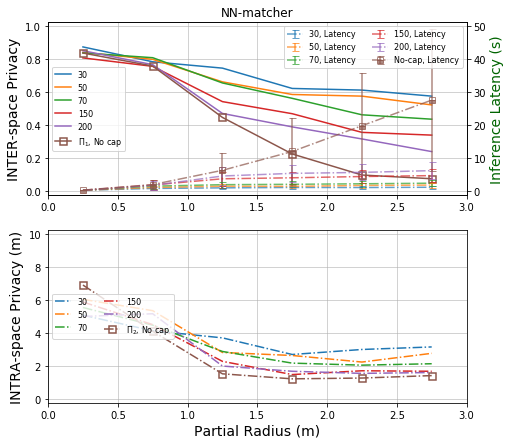

In [22]:
fig=plt.figure(figsize=(7.5, 7))

markersize = 7
linewidth = 1.5

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)
ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

with open('testing_results/partial_exp/results_partials_caps.pickle', 'rb') as f:
    results_partials_caps = pickle.load(f)
    
with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials = pickle.load(f)

RansacNN = np.asarray(results_partials[1])
    
for cap, ransac_errors, properties in results_partials_caps:

    ax2.plot(
        ransac_errors[:,0],
        ransac_errors[:,2],
        '-.',
        linewidth = linewidth,
        fillstyle = 'none',
        mew = linewidth,markersize = markersize,
        label = str(cap)
    )

    ax1.plot(
        ransac_errors[:,0],
        ransac_errors[:,1],
        "-",
        linewidth = linewidth,
        fillstyle = 'none',
        mew = linewidth,markersize = markersize,
        label = str(cap)
    )

    ax3.errorbar(
        properties[:,0],
        properties[:,3],
        properties[:,4],
        #marker = 's',
        alpha = 0.7,
        markersize = markersize-1,
        linestyle = '-.',
        fillstyle = 'bottom',
        #color = 'tab:green',
        capsize = markersize/2,
        label = str(cap)+", Latency"
    );

ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, No cap"
)

ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, No cap"
)

ax3.errorbar(
    no_cap_simp_properties[:,0],
    no_cap_simp_properties[:,3],
    no_cap_simp_properties[:,4],
    marker = 's',
    alpha = 0.7,
    markersize = markersize-1,
    linestyle = '-.',
    fillstyle = 'bottom',
    #color = 'tab:green',
    capsize = markersize/2,
    label = "No-cap, Latency"
);

ax2.legend(loc = "center left", ncol = 2,fontsize = 8);#, bbox_to_anchor=(1.1, 1.5));
ax1.legend(loc = "center left", ncol = 1, fontsize = 8);# bbox_to_anchor=(1.1, 1.5));

#handles, labels = ax1.get_legend_handles_labels()
#handles.append(p3), labels.append("Latency, Generalized")
#ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
ax3.legend(loc = 'upper right', ncol = 2, fontsize = 8)

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')


In [ ]:
# Original

results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 3.1, 0.5):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump(results_partials,f)

Text(0.5, 1.0, 'NN-matcher')

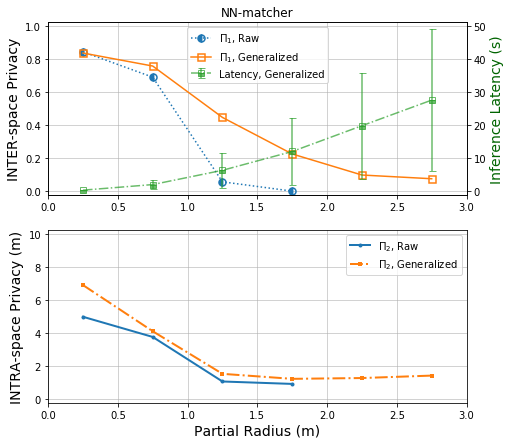

In [13]:
fig=plt.figure(figsize=(7.5, 7))

with open('testing_results/partial/results_partials_nn_matcher.pickle', 'rb') as f:
    results_partials = pickle.load(f)

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])
linewidth = 2.0
markersize = 2.0

ax2 = fig.add_subplot(212)#, sharex = ax1) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,3)

ax2.set_ylabel("INTRA-space Privacy (m)", fontsize = 14);
ax2.set_xlabel("Partial Radius (m)", fontsize = 14);
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_2$, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

ax1 = fig.add_subplot(211, sharex = ax2) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,3.0)
ax1.set_ylabel("INTER-space Privacy", fontsize = 14);
#ax1.set_xlabel("Partial Radius", fontsize = 14);

markersize = 7
linewidth = 1.5

p1 = ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Raw"
)
p2 = ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "$\Pi_1$, Generalized"
)

ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));
handles, labels = ax1.get_legend_handles_labels()

ax3 = ax1.twinx()
ax3.set_ylim(-1.25,51.25);
#ax1.set_xlim(0,2.0)
ax3.set_ylabel("Inference Latency (s)", fontsize = 14, color = 'darkgreen');

p3 = ax3.errorbar(
    overall_simp_properties[:,0],
    overall_simp_properties[:,3],
    overall_simp_properties[:,4],
    marker = 's',
    alpha = 0.7,
    markersize = markersize-1,
    linestyle = '-.',
    fillstyle = 'bottom',
    color = 'tab:green',
    capsize = markersize/2,
    label = "Latency"
);

handles.append(p3), labels.append("Latency, Generalized")
ax1.legend(handles, labels,loc = 'upper center', fontsize = 10)
#ax1.set_xlabel("Partial Radius")

plt.title("NN-matcher")

#plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')
